<a href="https://colab.research.google.com/github/yvonny/churn/blob/master/ChurnPredictionBaseline_1023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paper: https://www.andrew.cmu.edu/user/lakoglu/pubs/StackOverflow-churn.pdf

Description of datasets: https://ia800107.us.archive.org/27/items/stackexchange/readme.txt

Site for download of datasets: https://archive.org/details/stackexchange

This code has 6 steps

1. Load StackOverflow datasets as dataframe
2. Extract and label the datasets for each task
3. Extract features for each task
4. Analyze features
5. Train models for each task with the features
6. Quantify the importance of each feature category

1. Load StackOverflow datasets as dataframe

In [76]:
import sys
!{sys.executable} -m pip install xmltodict

In [0]:
import xmltodict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

In [0]:
def store_df_at_google_drive(fname, df, ftype=None):
    s = io.StringIO()
    if ftype == 'png':
      uploaded = gdrive.CreateFile({'title': fname, 'parents':[{'id': 'root'}]})
      uploaded.SetContentFile('%s.png'%(fname))
      uploaded.Upload()
      print('Uploaded file with ID {}'.format(uploaded.get('id')))
    else:
      df.to_csv(s)
      uploaded = gdrive.CreateFile({'title': fname, 'parents':[{'id': 'root'}]})
      uploaded.SetContentString(s.getvalue())
      uploaded.Upload()
      print('Uploaded file with ID {}'.format(uploaded.get('id')))

def load_df_at_google_drive(fname):
    file_list = gdrive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
    for file1 in file_list:
        if (file1['title'] == fname):
            downloaded = gdrive.CreateFile({'id': file1['id']})
            s = io.StringIO(downloaded.GetContentString())
            return pd.read_csv(s)
    
def load_dataset_from_google_drive(dir_id):
    files = []
    file_list = gdrive.ListFile({'q': "'{}' in parents".format(dir_id)}).GetList()
    for f in file_list:
      if f['title'] in ['Users.xml', 'Posts.xml','users_reduce.pkl', 'posts_reduce.pkl']:
          print('  Load file: {}'.format(f['title']))
          f_ = gdrive.CreateFile({'id': f['id']})
          f_.GetContentFile(f['title'])
          files.append(f['title'])
    return files

In [81]:
dfiles = load_dataset_from_google_drive('1Fp_7GDH_t7xfnU8aXeKrcBC54_nECOcu') 

  Load file: users_reduce.pkl
  Load file: posts_reduce.pkl


In [0]:
from google.colab import files

In [82]:
users_df = pd.read_pickle("{}.pkl".format('users_reduce'))   # shape: (992,110, 3)
posts_df = pd.read_pickle("{}.pkl".format('posts_reduce'))   # shape: (11,324,326, 10)

users_df.shape, posts_df.shape   # Total dataset

((992110, 3), (11324326, 10))

2. Extract and label the datasets for each tasks

You should extract the dataset for the period of the dataset: July 31, 2008 ~ July 31, 2012

There are 2 tasks:

A. After a user's K-th post, predict how likely it is that the user will churn

B. After the T-th day from the account creation of a user, predict how likely it is that the user will churn

In [83]:
def getIthOfPosts(posts):
    print('getIthOfPosts')
    posts.sort_values(by=['OwnerUserId', 'CreationDate'], inplace=True)
    posts.reset_index(level=0, inplace=True)
    posts['id_owner_time'] = posts.index
    first_posts = posts.groupby('OwnerUserId')['id_owner_time'].min().to_frame()
    tmp = posts.join(first_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    posts['ith'] = tmp['id_owner_timeF'] - tmp['id_owner_timeP'] + 1
    posts = posts.drop(['id_owner_time'], axis=1)
    return posts

# You should extract the dataset for the period of the dataset: July 31, 2008 ~  July 31, 2012
start_time = pd.to_datetime('2008-07-31')
end_time = pd.to_datetime('2012-07-31')
end_time_2 = pd.to_datetime('2012-01-31')

posts_df = posts_df[(posts_df['CreationDate'] >= start_time) & (posts_df['CreationDate'] <= end_time)]
users_df = users_df[(users_df['CreationDate'] >= start_time) & (users_df['CreationDate'] <= end_time_2)]


posts_df = getIthOfPosts(posts_df)

getIthOfPosts


In [0]:
# Dataset in Task 1
#   Posts: Extract K posts of each user
#   Users: Extract users who post at least K


def getTask1Posts(posts, K):
    tmp = posts[posts['ith'] == K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    tmp = posts[posts['OwnerUserId'].isin(tmp.index)]
    return tmp[tmp['ith'] <= K]


def getTask1Users(users, posts, K):
    users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= K]
    return users


In [0]:
list_of_K = range(1, 21)
users_of_task1, posts_of_task1 = {}, {}


for K in list_of_K:
    posts_of_task1[K] = getTask1Posts(posts_df, K)
    users_of_task1[K] = getTask1Users(users_df, posts_df, K)

In [86]:
# Churn in Task 1
#   Churners: Users who did not post for at least 6 months from their K-th post 
#   Stayers:  Users who created at least one post within the 6 months from their K-th post

def prepareFeaturesTask1(users, posts, K):
    tmp = posts[posts['ith']==K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    posts = posts[posts['OwnerUserId'].isin(tmp.index)]

    posts_task = posts[posts['OwnerUserId'].isin(users.index)]
    posts_Kth_time = posts_task[posts_task['ith']==K]
    posts_Kth_time = posts_Kth_time.set_index('OwnerUserId')['CreationDate']
    posts_deadline = posts_Kth_time + pd.tseries.offsets.DateOffset(months=6)
    
    posts_stayer = posts_task[posts_task['ith'] > K].groupby('OwnerUserId')['CreationDate'].min().to_frame()
    posts_stayer = posts_stayer.merge(posts_deadline, on='OwnerUserId', how='left', suffixes=('_left', '_right'))
    
    posts_churner1 = posts_stayer[posts_stayer['CreationDate_left'] > posts_stayer['CreationDate_right']]
    posts_churner1['is_churn'] = 1
    posts_churner1 = posts_churner1[['is_churn']]
    posts_stayer = posts_stayer[posts_stayer['CreationDate_left'] <= posts_stayer['CreationDate_right']]
    posts_stayer['is_churn'] = 0    
    posts_stayer = posts_stayer[['is_churn']]
       
    posts_churner2 = posts_task[posts_task['ith'] >= K].groupby('OwnerUserId').count()
    posts_churner2 = posts_churner2[posts_churner2['CreationDate'] == 1][['CreationDate']]
    posts_churner2['is_churn'] = 1
    posts_churner2 = posts_churner2[['is_churn']]
    
    posts = pd.concat([posts_stayer, posts_churner1, posts_churner2])
    posts = posts.rename(columns={'OwnerUserId': 'Id'})
    users['is_churn'] = 0
    users.update(posts)
    return users

features_of_task1 = {}

for K in list_of_K:
    features_of_task1[K] = prepareFeaturesTask1(users_of_task1[K], posts_df, K)
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [0]:
from google.colab import files

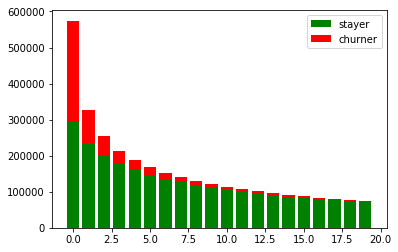

In [89]:
# Figure 1: Histogram of churning and staying users by post count (up to 20)

num_churners = []
num_stayers = []

for K in list_of_K:
  features = features_of_task1[K]
  nums = list(features.groupby('is_churn')['is_churn'].count())
  num_churners.append(nums[1])
  num_stayers.append(nums[0])

colorList=['g','r']
y = np.array([num_stayers, num_churners])


for i in range(y.shape[0]):
  plt.bar(np.arange(y.shape[1]), y[i], bottom=np.sum(y[:i], axis=0), color=colorList[(i % len(colorList))])
plt.legend(['stayer','churner'])
plt.savefig('Figure1.png')
# store_df_at_google_drive('Figure1',pd.DataFrame(), 'png')
# files.download('Figure1.png')
plt.show()


In [0]:
# Dataset in Task 2
#   Users: Extract users who post at least 1
#   Posts: Extract posts which create before T day from the account creation of the owner

def getCreationDateOfOwner(users, posts):
    posts['DataframeIndex'] = posts.index
    posts['CreationDateOfOwner'] = posts.set_index('OwnerUserId')\
            .join(users, how='inner', rsuffix='OfOwner')\
            .set_index('DataframeIndex')['CreationDateOfOwner']
    posts = posts.drop(['DataframeIndex'], axis=1)
    return posts['CreationDateOfOwner']

  
def getTask2Posts(users, posts, T):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    observation_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    posts = posts[posts['CreationDate'] <= observation_deadline]
    return posts
  
def getTask2Users(users, posts):
    users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= 1]
    return users
  
list_of_T = [7, 15, 30]
users_of_task2 = {}
posts_of_task2 = {}

for T in list_of_T:
    posts_of_task2[T] = getTask2Posts(users_df, posts_df, T)
    users_of_task2[T] = getTask2Users(users_df, posts_df)

In [91]:
# Churn in Task2
#   Churners: Users who did not post for at least 6 months from T days after account creation
#   Stayers:  Users who created at least one post within the 6 months from T days after account creation

def prepareFeaturesTask2(users, posts, T=30):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    users = getTask1Users(users, posts, K=1)
    observe_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    churn_deadline = observe_deadline + pd.tseries.offsets.DateOffset(months=6)
    posts_observed = posts[(posts['CreationDate'] <= observe_deadline) & (posts['CreationDate'] >= posts['CreationDateOfOwner'])]
    posts_after_observe = posts[(posts['CreationDate'] <= churn_deadline) & (posts['CreationDate'] > observe_deadline)]
    label_df = users.reindex((posts_observed.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index)
    stayers = (posts_after_observe.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index
    churners = list(set(label_df.index) - set(stayers))
    label_df['is_churn'] = 0.
    label_df.loc[churners, 'is_churn'] = 1.
    return label_df

features_of_task2 = {}
for T in list_of_T:
    features_of_task2[T] = prepareFeaturesTask2(users_of_task2[T], posts_df, T)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


3. Extract features for each task

3-1. Temporal features

In [0]:
# Temporal features 1: gap1
def getTimeGap1OfUser(users, posts):
    creation_date_user = users['CreationDate']
    creation_date_first_post = posts.groupby('OwnerUserId')['CreationDate'].min()
    return (creation_date_first_post - creation_date_user).dt.total_seconds()
  
# Temporal features 2: gapK

def getTimeGapkOfPosts(posts, k):
    date_1 = posts[posts['ith'] == (k-1)].sort_values('OwnerUserId')
    date_2 = posts[posts['ith'] == k].sort_values('OwnerUserId')
    date_2 = date_2.set_index('OwnerUserId')
    date_1 = date_1.set_index('OwnerUserId')
    result = (date_2['CreationDate'] - date_1['CreationDate']).dt.total_seconds() / 60  
    return result

  # Temporal features 3: last_gap (units : min)
def getTimeLastGapOfPosts(posts):
    last_posts = posts.groupby('OwnerUserId')['CreationDate'].max().to_frame()
    tmp = posts.join(last_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    tmp = tmp[tmp['CreationDateF'] < tmp['CreationDateP']].groupby('OwnerUserId')['CreationDateF'].max().to_frame()
    return (last_posts['CreationDate'] - tmp['CreationDateF']).dt.total_seconds() / 60
# Temporal features 4: time_since_last_post (units: min)
def getTimeSinceLastPost(users, posts, T):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    creation_after_T_days_date = users['CreationDate'] + pd.offsets.Day(T)
    return (creation_after_T_days_date - last_post_date).dt.total_seconds() / 60
# Temporal features 5: mean_gap
def getTimeMeanGap(posts):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    first_post_date = posts.groupby('OwnerUserId')['CreationDate'].min()
    num_posts = posts.groupby('OwnerUserId')['CreationDate'].count()
    return (last_post_date - first_post_date).dt.total_seconds() / 60 / num_posts
# Knowledge features 8: num_answers_recvd
def getAvgNumAnsReceived(users, answers, questions, qnta, tqna):
    #questions = posts[posts['PostTypeId'] == 1]
    return questions.fillna({'AnswerCount': 0}).groupby('OwnerUserId')['AnswerCount'].mean()
    

In [93]:
# Extract temporal features for task1
for K in list_of_K:
    features_of_task1[K]['gap1'] = getTimeGap1OfUser(users_of_task1[K], posts_of_task1[K])
    for k in range(2, K+1):
        features_of_task1[K]['gap{}'.format(k)] = getTimeGapkOfPosts(posts_of_task1[K], k)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

K=1


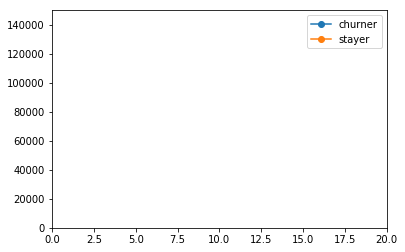

K=2


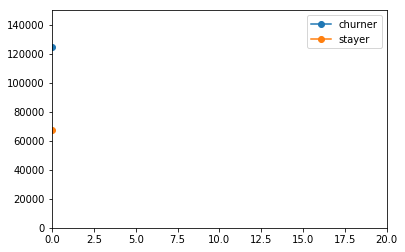

K=3


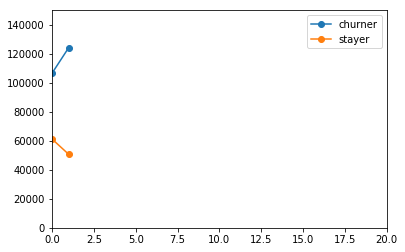

K=4


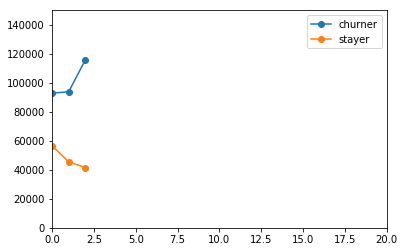

K=5


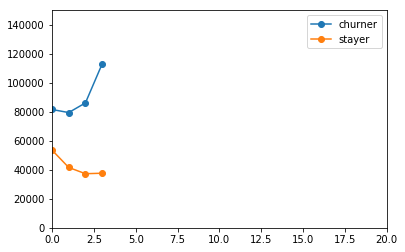

K=6


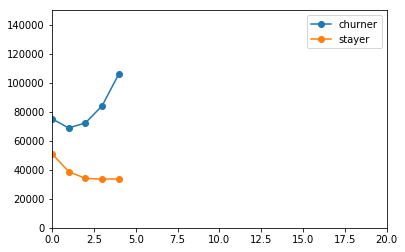

K=7


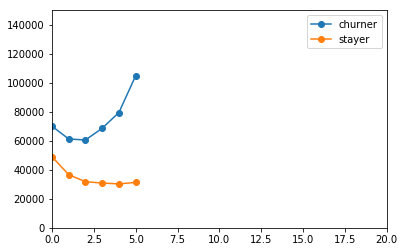

K=8


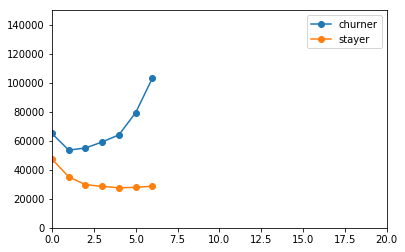

K=9


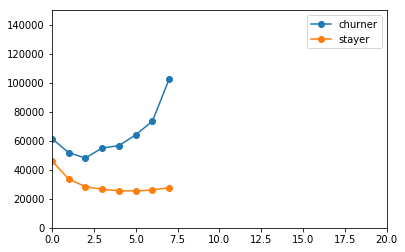

K=10


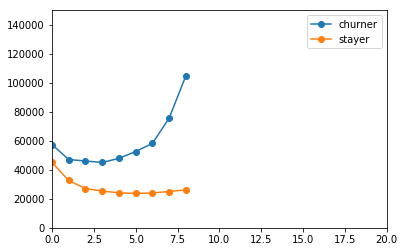

K=11


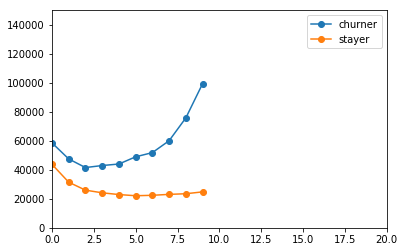

K=12


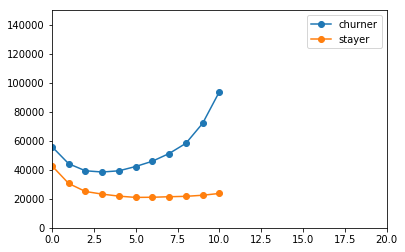

K=13


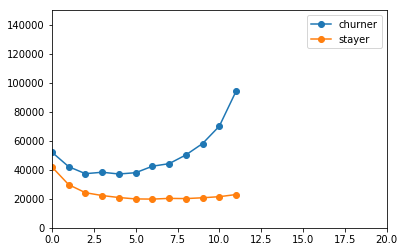

K=14


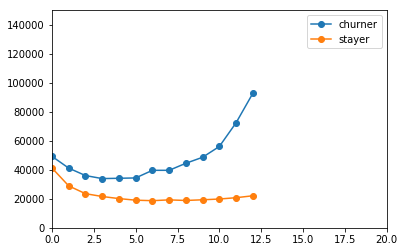

K=15


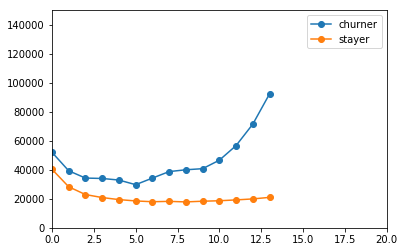

K=16


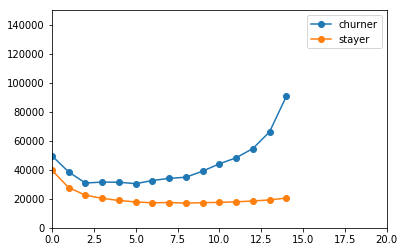

K=17


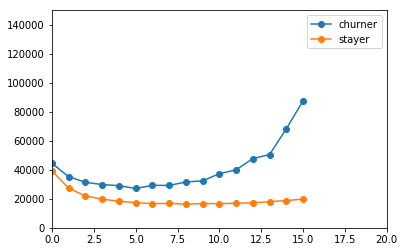

K=18


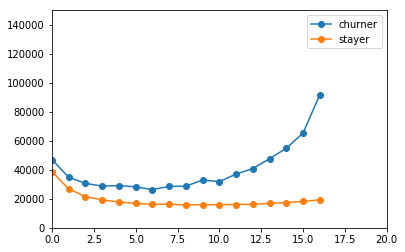

K=19


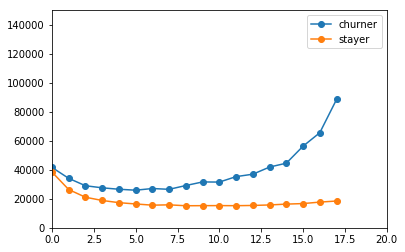

K=20


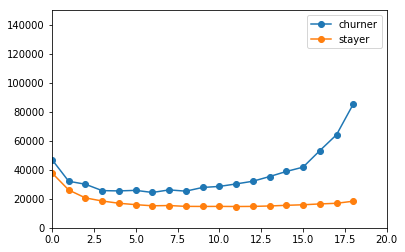

In [94]:
# Figure 2: Gap between posts
#    For a user who churns, gap between consecutive posts keeps increasing. 
#    Gaps for those who stay are much lower, and stabilize around 20,000 minutes,
#    indicating routine posting activity in every ≈2 weeks.
clist = []
slist = []
subt = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners_gap = []
    stayers_gap = []
    for i in range(2, K+1):
        gapK = 'gap{}'.format(i)
        sum_gapK = list(subgroup.groupby('is_churn')[gapK].sum())
        count_gapK = list(subgroup.groupby('is_churn')[gapK].count())
        if len(sum_gapK) < 2:
            break
        churners_gap.append(sum_gapK[1] / count_gapK[1])
        stayers_gap.append(sum_gapK[0] / count_gapK[0])
    subt.append('K = %s'%K)
    clist.append(churners_gap)
    slist.append(stayers_gap)
    
    print("K={}".format(K))
    plt.plot(churners_gap, '-o', label='churner')
    plt.plot(stayers_gap, '-o', label='stayer')
    plt.legend()
    plt.axis((0,20,0,15e4))
    
    plt.show()
#     files.download('task1_{0}posts_{1}.png'.format(K,'TimeGap1OfUser'))

Uploaded file with ID 10hIZUZIvTwKrZNpvYteWEPsy_rLGbFZQ


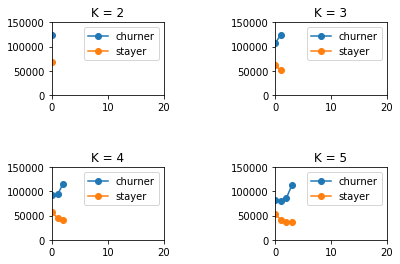

Uploaded file with ID 1KePyTb8EGhqraGlmsGmFmvCy4kQtXz-G


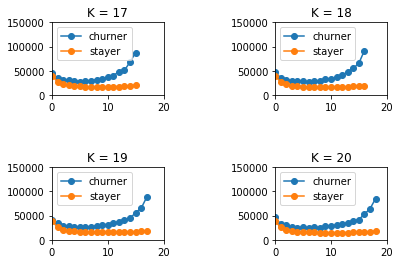

In [34]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axlist = [ax1, ax2, ax3, ax4]
for c, s, ax,t in zip(clist[1:], slist[1:], axlist, subt[1:]):
    ax.plot(c, '-o', label='churner')
    ax.plot(s, '-o', label='stayer')
    ax.legend()
    ax.axis((0,20,0,15e4))
    ax.set_title(t)
fig.subplots_adjust(wspace=1, hspace=1)
plt.savefig('Task1_Figure2_1.png')
store_df_at_google_drive('Task1_Figure2_1',pd.DataFrame(), 'png')
# files.download('Task1_Figure2_1.png')
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axlist = [ax1, ax2, ax3, ax4]
for c, s, ax, t in zip(clist[-4:], slist[-4:], axlist, subt[-4:]):
    ax.plot(c, '-o', label='churner')
    ax.plot(s, '-o', label='stayer')
    ax.legend()
    ax.axis((0,20,0,15e4))
    ax.set_title(t)
fig.subplots_adjust(wspace=1, hspace=1)
plt.savefig('Task1_Figure2_2.png')
store_df_at_google_drive('Task1_Figure2_2',pd.DataFrame(), 'png')
# files.download('Task1_Figure2_2.png')
plt.show()


In [0]:
# Extract temporal features for task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['gap1'] = getTimeGap1OfUser(users, posts)
    features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(features_of_task2[T]['gap1'])
    #features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(0)
    features_of_task2[T]['time_since_last_post'] = getTimeSinceLastPost(users, posts, T)
    features_of_task2[T]['mean_gap'] = getTimeMeanGap(posts)
  


3-2. Frequency features

In [0]:
# Frequency features 1: num_answers
# Frequency features 2: num_questions
def getNumAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['OwnerUserId'].count()

def getNumQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['OwnerUserId'].count()


In [0]:
from google.colab import files

In [0]:
# Frequency features 3: ans_ques_ratio
def getAnsQuesRatio(num_answers, num_questions):
    # Use Laplace Smoothing
    return (num_answers + 1) / (num_questions + 1)
# Frequency features 4: num_posts
def getNumPosts(posts):
    return posts.groupby('OwnerUserId')['OwnerUserId'].count().astype('float')

In [98]:
# Extract frequency features of task1
for K in list_of_K:
    users, posts = users_of_task1[K], posts_of_task1[K]
    features_of_task1[K]['num_answers'] = getNumAnswers(posts)
    features_of_task1[K]['num_questions'] = getNumQuestions(posts)
    features_of_task1[K] = features_of_task1[K].fillna({'num_answers':0, 'num_questions':0})
    features_of_task1[K]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task1[K]['num_answers'], features_of_task1[K]['num_questions'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
# Extract frequency features of task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['num_answers'] = getNumAnswers(posts)
    features_of_task2[T]['num_questions'] = getNumQuestions(posts)
    features_of_task2[T] = features_of_task2[T].fillna({'num_answers':0,'num_questions':0})
    features_of_task2[T]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task2[T]['num_answers'], features_of_task2[T]['num_questions'])
    features_of_task2[T]['num_posts'] = getNumPosts(posts)

In [0]:
from google.colab import files

# Answers vs Churn probability
Uploaded file with ID 1-AFWRes0eNICyOrBMlmlyepXleSh3qM0


MessageError: ignored

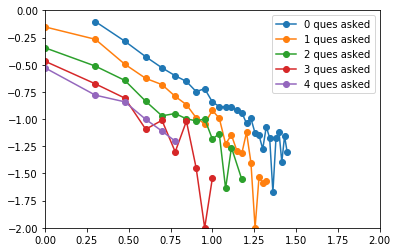

In [100]:
# Figure 3: # Answers vs Churn probability
#    The probability of churning for a user decreases the more answers s/he provides.
#    It is even lower if s/he asks more questions alongside.

min_num_users = 50
for T in list_of_T:
    task2 = features_of_task2[T]
    for num_que_ask in range(5):
        subgroup = task2[task2['num_questions'] == num_que_ask]
        churn_probs = []
        num_answers = list(set(subgroup['num_answers']))
        num_answers.sort()
        for num_ans in num_answers:
            subsubgroup = subgroup[subgroup['num_answers'] == num_ans]
            prob = sum(subsubgroup['is_churn']) / subsubgroup.shape[0]
            if subsubgroup.shape[0] >= min_num_users:
                churn_probs.append((num_ans, prob))

        plt.plot([np.log10(x[0]+1) for x in churn_probs],
                 [np.log10(x[1]+0.01) for x in churn_probs],
                 '-o',
                 label='{} ques asked'.format(num_que_ask))
    print("# Answers vs Churn probability")
    plt.legend()
    plt.axis((0,2,-2,0))
    
    plt.savefig('Task2_T{}_churn_prob.png'.format(T))
    store_df_at_google_drive('Task2_T{}_churn_prob'.format(T), pd.DataFrame(),'png')
    
#     files.download('Task2_T{}_churn_prob.png'.format(T))
    plt.show()

3-3. Knowledge features

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask1(users, posts, all_posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    all_answers = all_posts[all_posts['PostTypeId'] == 2]
    all_questions = all_posts[all_posts['PostTypeId'] == 1]

    qnta = all_answers.set_index('ParentId')\
        .join(questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    tqna = answers.set_index('ParentId')\
        .join(all_questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    return answers, questions, qnta, tqna

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask2(users, posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    qna = answers\
        .set_index('ParentId').join(questions, how='inner',\
                                    lsuffix='A', rsuffix='Q')
    return answers, questions, qna, qna

In [0]:
# Knowledge features 1: accepted_answerer_rep
def getRepOfAcceptedAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta[qnta['AcceptedAnswerIdQ'] == qnta['IdA']]\
        .set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans
# Knowledge features 2: max_rep_answerer 
def getMaxRepAmongAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]
    rep_max_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].max()
    return rep_max_ans
# Knowledge features 3: num_que_answered
def getNumQueAnswered(users, answers, questions, qnta, tqna):
    # number of questions posted by the user that got answered
    #questions = posts[posts['PostTypeId'] == 1]
    answered_questions = questions[questions['AnswerCount'] > 0]
    return answered_questions.groupby('OwnerUserId')['AnswerCount'].count()
# Knowledge features 4: time_for_first_ans , unit : mins
def getTimeForFirstAns(users, answers, questions, qnta, tqna):
    tmp =  qnta[qnta['CreationDateQ'] < qnta['CreationDateA']]
    tmp['time_for_ans'] = (tmp['CreationDateA'] - tmp['CreationDateQ']).dt.total_seconds() / 60
    questions['time_for_first_ans'] = tmp.groupby(by=tmp.index)['time_for_ans'].min()
    return questions.groupby('OwnerUserId')['time_for_first_ans'].mean()
# Knowledge features 5: rep_questioner
def getAvgRepOfQuestioner(users, answers, questions, qnta, tqna):
    # Avg. reputation of the user whose question was answered
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = tqna.set_index('OwnerUserIdQ')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdA')['Reputation'].mean()
    return rep_accepted_ans
# Knowledge features 6: rep_answerers
def getAvgRepOfAnswerer(users, answers, questions, qnta, tqna):
    # Avg. reputation of the users who answered the question
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans
# Knowledge features 7: rep_co_answerers
def getAvgRepOfCoAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]    
    rep_ans = answers.set_index('OwnerUserId')\
        .join(reputations, how='inner')\
        .set_index('ParentId')\
        .join(questions, how='inner', lsuffix='A', rsuffix='Q')
    avg_rep_ans = rep_ans.groupby(by=rep_ans.index)['Reputation'].mean()
    rep_co_answerer = answers.set_index('ParentId')\
        .join(avg_rep_ans, how='inner')\
        .set_index('OwnerUserId')
    return rep_co_answerer.groupby(by=rep_co_answerer.index)['Reputation'].mean()
# Knowledge features 8: num_answers_recvd
def getAvgNumAnsReceived(users, answers, questions, qnta, tqna):
    #questions = posts[posts['PostTypeId'] == 1]
    return questions.fillna({'AnswerCount': 0}).groupby('OwnerUserId')['AnswerCount'].mean()


In [105]:
# Extract knowledge features of task 1
for K in list_of_K:
    print("Extract knowledge features of task1(K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    answers, questions, qnta, tqna = preprocessForKnowledgeFeaturesForTask1(users, posts, posts_df)
    features_of_task1[K]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['max_rep_answerer'] = getMaxRepAmongAnswerer(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['num_que_answered'] = getNumQueAnswered(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['time_for_first_ans'] = getTimeForFirstAns(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_questioner'] = getAvgRepOfQuestioner(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_answerers'] = getAvgRepOfAnswerer(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_co_answerers'] = getAvgRepOfCoAnswerer(users, answers, questions, qnta, tqna)
    features_of_task1[K]['num_answers_recvd'] = getAvgNumAnsReceived(users, answers, questions, qnta, tqna)

Extract knowledge features of task1(K= 1 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Extract knowledge features of task1(K= 2 )
Extract knowledge features of task1(K= 3 )
Extract knowledge features of task1(K= 4 )
Extract knowledge features of task1(K= 5 )
Extract knowledge features of task1(K= 6 )
Extract knowledge features of task1(K= 7 )
Extract knowledge features of task1(K= 8 )
Extract knowledge features of task1(K= 9 )
Extract knowledge features of task1(K= 10 )
Extract knowledge features of task1(K= 11 )
Extract knowledge features of task1(K= 12 )
Extract knowledge features of task1(K= 13 )
Extract knowledge features of task1(K= 14 )
Extract knowledge features of task1(K= 15 )
Extract knowledge features of task1(K= 16 )
Extract knowledge features of task1(K= 17 )
Extract knowledge features of task1(K= 18 )
Extract knowledge features of task1(K= 19 )
Extract knowledge features of task1(K= 20 )


In [0]:
for T in list_of_T:
    print("Extract knowledge features of task2(T=)",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, questions, qna, qna1 = preprocessForKnowledgeFeaturesForTask2(users, posts)
    features_of_task2[T]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['max_rep_answerer'] = getMaxRepAmongAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['num_que_answered'] = getNumQueAnswered(users, answers, questions, qna, qna1)
    features_of_task2[T]['time_for_first_ans'] = getTimeForFirstAns(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_questioner'] = getAvgRepOfQuestioner(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_answerers'] = getAvgRepOfAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_co_answerers'] = getAvgRepOfCoAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['num_answers_recvd'] = getAvgNumAnsReceived(users, answers, questions, qna, qna1)

In [0]:
from google.colab import files


[251800.78674816707, 248688.8457336717, 244364.18028457422, 244817.5571939107, 243631.4163717619, 242736.60375128855, 242907.2289805491, 241128.17010798235, 243723.95503069003, 242302.81516570252, 240581.88701730903, 241285.55914207167, 245013.14743117432, 244670.2924921883, 240700.91261475967, 245045.8896999932, 244334.71034029542, 238544.8833009292, 246428.93019253, 247808.2126234231]
[262644.44214010047, 259470.27775569318, 258635.93794273748, 257508.4095605074, 256772.08052345354, 256079.1675306655, 255926.83202625255, 255570.13058080323, 255378.73499178753, 255078.55852758433, 255174.7359551613, 255092.94221397335, 254729.87849407468, 254903.09193956357, 254776.33941298758, 254040.6209540422, 253956.16359804463, 254138.69558799884, 253565.95645133936, 253259.0204837794]


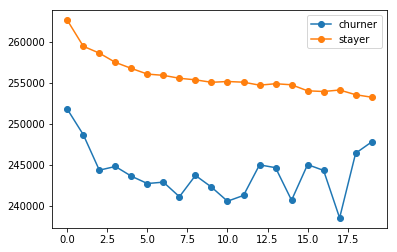

In [46]:
# Figure 4: K vs Time taken for the first answer to arrive
#  The more the time taken for a user to receive an answer, 
#  the lesser the satisfaction level and the more the chances of churning.
churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    subgroup = subgroup.fillna({'time_for_first_ans': -1})
    subgroup = subgroup[subgroup['time_for_first_ans'] >= 0]
    churners = subgroup[subgroup['is_churn'] == 1]
    stayers = subgroup[subgroup['is_churn'] == 0]
    churners_time.append(churners['time_for_first_ans'].mean())
    stayers_time.append(stayers['time_for_first_ans'].mean())
    

print(churners_time)
print(stayers_time)

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.show()

In [0]:
# Figure 4: K vs Time taken for the first answer to arrive
#  The more the time taken for a user to receive an answer, 
#  the lesser the satisfaction level and the more the chances of churning.

churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners = subgroup[subgroup['is_churn'] == 1][subgroup['time_for_first_ans'] >= 0] 
    stayers = subgroup[subgroup['is_churn'] == 0][subgroup['time_for_first_ans'] >= 0]
    churners_time.append(churners['time_for_first_ans'].mean())
    stayers_time.append(stayers['time_for_first_ans'].mean())
    

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.savefig('Task1_Figure4.png')
store_df_at_google_drive('Task1_Figure4',pd.DataFrame(),'png')
# files.download('Task1_Figure4.png')
plt.show()

Implement the other features yourself!!

3-4. Speed features

In [0]:
# Speed features 1: answering_speed
def getAnsweringSpeed(questions_df, answers_df):
    answers_df = posts[posts['PostTypeId'] == 2]
    questions_df = posts[posts['PostTypeId'] == 1]
    
    qna = answers_df.set_index('ParentId')\
        .join(questions_df, how='inner', lsuffix='A', rsuffix='Q')
    qna = qna[qna['CreationDateQ'] < qna['CreationDateA']]
    qna['time_for_ans'] = (qna['CreationDateA'] - qna['CreationDateQ']).dt.total_seconds() // 60
    return 1 / qna.groupby('OwnerUserIdA')['time_for_ans'].mean()

In [0]:
answers = posts_df[posts_df['PostTypeId'] == 2]
for K in list_of_K:
  questions = posts_of_task1[K]
  questions = [questions['PostTypeId'] == 1]
  features_of_task1[K]['answering_speed'] = getAnsweringSpeed(questions, answers)  

In [0]:
for T in list_of_T:
  posts = posts_of_task2[T]
  questions = posts[posts['PostTypeId'] == 1]
  answers = posts[posts['PostTypeId'] == 2]
  features_of_task2[T]['answering_speed'] = getAnsweringSpeed(questions, answers)

3-5. Quality features



In [0]:
# Quality features 1: ans_score
# Quality features 2: que_score
def getScoreOfAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['Score'].mean()

def getScoreOfQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['Score'].mean()

In [0]:
for K in list_of_K:
  posts = posts_of_task1[K]
  features_of_task1[K]['score_of_answers'] = getScoreOfAnswers(posts)
  features_of_task1[K]['score_of_questions'] = getScoreOfQuestions(posts) 

In [0]:
for T in list_of_T:
  posts = posts_of_task2[T]
  features_of_task2[T]['score_of_answers'] = getScoreOfAnswers(posts)
  features_of_task2[T]['score_of_questions'] = getScoreOfQuestions(posts) 

3-6. Consistency features



In [0]:
# Consistency features 1: ans_stddev
# Consistency features 2: que_stddev
def getStdevOfScoresOfAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['Score'].std()

def getStdevOfScoresOfQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['Score'].std()


In [0]:
for K in list_of_K:
  posts = posts_of_task1[K]
  features_of_task1[K]['stdev_of_answers'] = getStdevOfScoresOfAnswers(posts)
  features_of_task1[K]['stdev_of_questions'] = getStdevOfScoresOfQuestions(posts)

In [0]:
for K in list_of_T:
  posts = posts_of_task2[T]
  features_of_task2[T]['stdev_of_answers'] = getStdevOfScoresOfAnswers(posts)
  features_of_task2[T]['stdev_of_questions'] = getStdevOfScoresOfQuestions(posts)

3-7. Gratitude features



In [0]:
# Gratitude features 1: ans_comments
# Gratitude features 2: que_comments
def getAvgNumOfCommentsOfAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['CommentCount'].mean()

def getAvgNumOfCommentsOfQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['CommentCount'].mean()

In [0]:
for K in list_of_K:
  posts = posts_of_task1[K]
  features_of_task1[K]['avg_num_comments_of_answers'] = getAvgNumOfCommentsOfAnswers(posts)
  features_of_task1[K]['avg_num_comments_of_questions'] = getAvgNumOfCommentsOfQuestions(posts)

In [0]:
for K in list_of_T:
  posts = posts_of_task2[T]
  features_of_task2[T]['avg_num_comments_of_answers'] = getAvgNumOfCommentsOfAnswers(posts)
  features_of_task2[T]['avg_num_comments_of_questions'] = getAvgNumOfCommentsOfQuestions(posts)

3-8. Competitiveness features



In [0]:
# Competitiveness features 1: relative_rank_pos --> Strange..
def getRelativeRankPos(posts):
    # average of total # of answers for a question divided by the rank of user’s answer
    answers_df = posts[posts['PostTypeId'] == 2]
    ans_rank = answers_df.groupby('ParentId')['Score'].rank(method='average')
    ans_count = answers_df.groupby('ParentId')['Score'].transform('count')
#     answers_copy = answers_df.copy()
#     answers_copy['RelRankPos'] =  ans_count / ans_rank
    answers_copy = pd.DataFrame({
        'OwnerUserId': answers_df['OwnerUserId'],
        'RelRankPos': ans_count / ans_rank,
    })
    return answers_copy.groupby('OwnerUserId')['RelRankPos'].mean()

  

In [0]:
for K in list_of_K:
  posts = posts_of_task1[K]
  features_of_task1[K]['relative_rank_pos'] = getRelativeRankPos(posts)

In [0]:
for T in list_of_T:
  posts = posts_of_task2[T]
  features_of_task2[T]['relative_rank_pos'] = getRelativeRankPos(posts)

3-9. Content features

In [0]:
# Content features 1: ans_length
# Content features 2: que_length
    # Length is the word counts
def getAvgLengthOfAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    if 'BodyWordNum' in posts.columns:
        return answers.groupby('OwnerUserId')['BodyWordNum'].mean()
    return answers.groupby('OwnerUserId')['Body'].apply(lambda r: r.str.split().str.len().mean())

def getAvgLengthOfQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    if 'BodyWordNum' in posts.columns:
        return questions.groupby('OwnerUserId')['BodyWordNum'].mean()
    return questions.groupby('OwnerUserId')['Body'].apply(lambda r: r.str.split().str.len().mean())


In [0]:
for K in list_of_K:
  posts = posts_of_task1[K]
  features_of_task1[K]['avg_length_of_answers'] = getAvgLengthOfAnswers(posts)
  features_of_task1[K]['avg_length_of_questions'] = getAvgLengthOfQuestions(posts)

In [0]:
for T in list_of_T:
  posts = posts_of_task2[T]
  features_of_task2[T]['avg_length_of_answers'] = getAvgLengthOfAnswers(posts)
  features_of_task2[T]['avg_length_of_questions'] = getAvgLengthOfQuestions(posts)

In [124]:
# Store the whole features of task1 to Google Drive
for K in list_of_K:
    features_of_task1[K].to_pickle('task1_{}posts_features.pkl'.format(K))
    features_of_task1[K].to_csv('task1_{}posts_features.csv'.format(K))
    store_df_at_google_drive('task1_{}posts_features.csv'.format(K), features_of_task1[K])
    

Uploaded file with ID 14EjrdAD2EzSeWm4qtdC0x5E9Eq_1db2w
Uploaded file with ID 13O_YluxD_rN8g-bLqDK5lEnjNbBUjULU
Uploaded file with ID 1B8IX5-EbbyZ51Ckp3U2GCAaXuZnq1x55
Uploaded file with ID 1b0HdPWRDFob59o8MDoui8InAsfRItzvI
Uploaded file with ID 1vCiPa1q8v3Ki7Ne17e-BeUyTZmKSmrkW
Uploaded file with ID 14LDwYFIrOWSpDAumJgiMkniFKrYvTPHc
Uploaded file with ID 1hZVY2asJTcIHROvsQ7MN1IH_f8Ls48FX
Uploaded file with ID 1bCHqDyb16gRn3af9Zxlbs_LBYdk-tTqf
Uploaded file with ID 1rjqjZkvQ6EN8ltD4k5JJDI0esPx7DOBz
Uploaded file with ID 1j8YUZs2SbcA2_Mmk79W0DzmwUssYmRdH
Uploaded file with ID 1ZrWvQqwwCe_XNqjyc1XySsSoWd6Jwz4U
Uploaded file with ID 1c2OiRzFMEaPWi70Ja5EWjIQGTwXPRtAX
Uploaded file with ID 1NK1L2XUb5MXZv43VlXD9qwXcUwZYDyDL
Uploaded file with ID 14FqiVluggp4jo5L9_uYKtU_1f2XzefaB
Uploaded file with ID 1LqAURFAo0qbdFla1-ge8w-QXCvBqNqvZ
Uploaded file with ID 10WCIDjILumQmXBvyOzkZrX26wIubY-GC
Uploaded file with ID 1aE8wED-l8KkRwMGHZUxOsRahgsShF-qy
Uploaded file with ID 12_XSE1Rc_2cgaFH5WUN3jiyzC

In [0]:
files_list=[]
filenames=[]
for K in list_of_K:
    files_list.append('/content/'+'task1_{}posts_features.csv'.format(K))
    filenames.append('task1_{}posts_features.csv'.format(K))
#     features_of_task1[K] = load_df_at_google_drive('task1_{}posts_features.csv'.format(K))
#     features_of_task1[K].to_csv('task1_{}posts_features.csv'.format(K))
    

for T in list_of_T:
    
#     features_of_task2[T].to_pickle('task2_{}days_features.pkl'.format(T))
#     features_of_task2[T].to_csv('task2_{}days_features.csv'.format(T))
#     store_df_at_google_drive('task2_{}days_features.csv'.format(T), features_of_task2[T])
    files_list.append('/content/'+'task2_{}days_features.csv'.format(T))
    filenames.append('task2_{}days_features.csv'.format(T))

In [137]:
!pwd

/content


In [134]:
user = 'yvonny'
password = '!@dmdld90'

g = Github(user,password)
rep = g.get_user().get_repo('churn')
print(rep)


Repository(full_name="yvonny/churn")


In [146]:
elist =[]
for i, entry in enumerate(files_list):
    with open(entry) as input_file:
      data = input_file.read()
    element = InputGitTreeElement(filenames[i],'100644','blob',data)
    elist.append(element)
master_ref = rep.get_git_ref('heads/master')
master_sha = master_ref.object.sha          
base_tree = rep.get_git_tree(master_sha)
tree=rep.create_git_tree(elist, base_tree)
parent = rep.get_git_commit(master_sha)
commit = rep.create_git_commit('feature files', tree,[parent])
master_ref.edit(commit.sha)

ConnectionError: ignored

In [131]:
!pip install -U -q PyGithub
from github import Github
from github import InputGitTreeElement

     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
from google.colab import files
from github import Github
from github import InputGitTreeElement

5. Train models for each tasks with the features

    1. Decision Tree
    2. SVM (Linear)
    3. SVM (RBF)
    4. Logistic Regression

In [0]:
# # Load features of task1
# # You can change the runtime to use GPU. It means you should load the features which you stored
features_of_task1 = {}
list_of_K = range(1, 21)
for K in list_of_K:
#     features_of_task1[K].to_csv('task1_{}posts_features.csv'.format(K))
#     store_df_at_google_drive('task1_{}posts_features.csv'.format(K), features_of_task1[K])
#     files.download('task1_{}posts_features.csv'.format(K))
  features_of_task1[K] = load_df_at_google_drive('task1_{}posts_features.csv'.format(K))

In [0]:
# Load features of task2
# You can change the runtime to use GPU. It means you should load the features which you stored
features_of_task2 = {}
list_of_T = [7, 15, 30]
for T in list_of_T:
    features_of_task2[T] = load_df_at_google_drive('task2_{}posts_features.csv'.format(T))

In [0]:
def fill_nan(features):
    if 'time_for_first_ans' in features.columns and np.isnan(features['time_for_first_ans']).sum(0):
        features['time_for_first_ans'] = 1 / features['time_for_first_ans']
        features['time_for_first_ans'] = features['time_for_first_ans'].replace([np.nan], 0)
    fill_constants = {
        'accepted_answerer_rep': 0,
        'max_rep_answerer': 0,
        'num_que_answered': 0, 
        'rep_questioner': 0,
        'rep_answerers': 0,
        'rep_co_answerers': 0,
        'num_answers_recvd': 0,
        'answering_speed': 0,
        'score_of_answers': 0,
        'score_of_questions': 0,
        'stdev_of_answers': 0,
        'stdev_of_questions': 0,
        'avg_num_comments_of_answers': 0,
        'avg_num_comments_of_questions': 0,
        'relative_rank_pos': 1,
        'avg_length_of_answers': 0,
        'avg_length_of_questions': 0,
    }
    return features.fillna(fill_constants)
                                                                         

In [153]:
for K in list_of_K:
    print("Fill NaN of task1(K=",K,")")
    features_of_task1[K] = fill_nan(features_of_task1[K])


Fill NaN of task1(K= 1 )
Fill NaN of task1(K= 2 )
Fill NaN of task1(K= 3 )
Fill NaN of task1(K= 4 )
Fill NaN of task1(K= 5 )
Fill NaN of task1(K= 6 )
Fill NaN of task1(K= 7 )
Fill NaN of task1(K= 8 )
Fill NaN of task1(K= 9 )
Fill NaN of task1(K= 10 )
Fill NaN of task1(K= 11 )
Fill NaN of task1(K= 12 )
Fill NaN of task1(K= 13 )
Fill NaN of task1(K= 14 )
Fill NaN of task1(K= 15 )
Fill NaN of task1(K= 16 )
Fill NaN of task1(K= 17 )
Fill NaN of task1(K= 18 )
Fill NaN of task1(K= 19 )
Fill NaN of task1(K= 20 )


In [154]:
for T in list_of_T:
    print("Fill NaN of task2(T=)",T,")")
    features_of_task2[T] = fill_nan(features_of_task2[T])


Fill NaN of task2(T=) 7 )
Fill NaN of task2(T=) 15 )
Fill NaN of task2(T=) 30 )


In [155]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1

--2019-10-23 04:52:33--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.189.146
Connecting to developer.nvidia.com (developer.nvidia.com)|192.229.189.146|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64.deb?3IGeuYpLj2W_NjMSLwN6td6D_htvJ_sqb2I88oKbIerz9tET8neDC632181YKzXpyyc1VHlQFhnv0lf_9FrKDe39ujRyWdRnBnhbG2aJaclN4qu_8KuE8-OOqVvuNAQ3wTGqLXOrd9BVRp3wVhD3YXnCI6T-XATmIKK87Evyn9Gy83-7VKrTjoD684u9K1GqM-brv7KrCdMH1VXSGewx [following]
--2019-10-23 04:52:34--  https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64.deb?3IGeuYpLj2W_NjMSLwN6td6D_htvJ_sqb2I88oKbIerz9tET8neDC632181YKzXpyyc1VHlQFhnv0lf_9FrKDe39ujRyWdRnBnhbG2aJaclN4q

In [156]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176


In [157]:
!pip3 install thundersvm

In [0]:
from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
from thundersvm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

seed = 1234
np.random.seed(seed)

max_iter=1e2

def LogisticRegression_(*arg, **kwarg):
    kwarg['max_iter'] = max_iter
    kwarg['solver'] = 'saga'
    kwarg['n_jobs'] = 8
    return LogisticRegression(*arg, **kwarg)

def SVC_rbf(*arg, **kwarg):
#     kwarg['max_iter'] = max_iter
    kwarg['kernel'] = 'rbf'
#     kwarg['n_jobs'] = 8
    return SVC(*arg, **kwarg)

def SVC_linear(*arg, **kwarg):
#     kwarg['max_iter'] = max_iter
    kwarg['kernel'] = 'linear'
#     kwarg['n_jobs'] = 8
    return SVC(*arg, **kwarg)
  

In [0]:
import time

In [0]:
def learn_model(data, train_features, target='is_churn', model=DecisionTreeClassifier, seed=seed):
    X = data[train_features]
    y = data[target]
    print(model.__name__)
        
    ### 10-fold cross validation ###
    acc_list = []
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        ### Under-sampling ###
        churners = y_train[y_train == 1].index
        stayers = y_train[y_train == 0].index
        n_churn = len(churners)
        n_stay = len(stayers)
        print('churn : {}, stay : {}'.format(n_churn, n_stay))
        if n_churn > n_stay:
            churners = np.random.choice(churners, n_stay, replace=False)
        else:
            stayers = np.random.choice(stayers, n_churn, replace=False)
        print('after sampling : churn : {}, stay : {}'.format(len(churners),len(stayers))) 
        train_index = np.array(list(churners) + list(stayers))
        X_train, y_train = X.reindex(train_index), y.reindex(train_index)

        ### Learn Model ###
        start_time= time.time()
        mdl = model().fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
        pred = mdl.predict(X_test)
        acc = (pred == y_test)
        acc_list.append(sum(acc)*100/len(acc))
    return acc_list

In [0]:
acc_df = pd.DataFrame(columns=['DT','LR'])

# acc_df.loc[len(acc_df)][0] = [0]
# acc_df.set_value(len(acc_df),'DT',1)
# acc_df

In [162]:
# Table 2: Performance on Task 1

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate', 'num_posts']
models=[ DecisionTreeClassifier, LogisticRegression_]
modelname=['DT','LR']
# models = [SVC_rbf, SVC_linear, DecisionTreeClassifier, LogisticRegression_]
# models = [LogisticRegression_, SVC]
for i in range(len(models)):
# for i in range(2):
# i=1
  model = models[i]
  for K in list_of_K:
    stime = time.time()
    print('Task 1,model={}, K={}, start : {}'.format(i,K, stime))
    train_features = [col for col in features_of_task1[K].columns 
                      if col not in drop_user_columns + ['is_churn']]
    acc_list = learn_model(features_of_task1[K], train_features, model=model)
    acc_df.set_value(K,modelname[i],np.mean(acc_list))
    print('Accuracy: {}, VAR : {} '.format(np.mean(acc_list), np.var(acc_list)))
    print('    for each folds: {}'.format(acc_list))
    print('end : {0}, execution time : {1}'.format(time.time(), time.time()-stime))


Task 1,model=0, K=1, start : 1571806573.7787077
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',
       'avg_length_of_answers', 'avg_length_of_questions'],
      dtype='object')
['Id', 'gap1', 'num_answers', 'num_questions', 'ans_que_ratio', 'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered', 'time_for_first_ans', 'rep_questioner', 'rep_answerers', 'rep_co_answerers', 'num_answers_recvd', 'answering_speed', 'score_of_answers', 'score_of_questions', 'stdev_of_answers', 'stdev_of_questions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 58.66071945149471, VAR : 0.042593254002387275 
    for each folds: [58.41589330176031, 58.84247732140059, 58.3462469312068, 58.68679481821981, 59.0576681989135, 58.44302827691879, 58.76863072851372, 58.669382922412595, 58.77559548683661, 58.60147652876445]
end : 1571806660.9730022, execution time : 87.19429469108582
Task 1,model=0, K=2, start : 1571806660.9730356
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'num_answers', 'num_questions',
       'ans_que_ratio', 'accepted_answerer_rep', 'max_rep_answerer',
       'num_que_answered', 'time_for_first_ans', 'rep_questioner',
       'rep_answerers', 'rep_co_answerers', 'num_answers_recvd',
       'answering_speed', 'score_of_answers', 'score_of_questions',
       'stdev_of_answers', 'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',
       'avg_length_of_answers', 'avg_length_of_questions'],
      dtype='

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 56.55345603773007, VAR : 0.07228387668928402 
    for each folds: [56.21841790953358, 56.797231494809054, 56.913606713012584, 56.539981012464395, 56.971794322114356, 56.31641809328392, 56.61960616176155, 56.23066793250237, 56.28273053011974, 56.64410620769914]
end : 1571806696.7208898, execution time : 35.747854709625244
Task 1,model=0, K=3, start : 1571806696.7210045
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'num_answers', 'num_questions',
       'ans_que_ratio', 'accepted_answerer_rep', 'max_rep_answerer',
       'num_que_answered', 'time_for_first_ans', 'rep_questioner',
       'rep_answerers', 'rep_co_answerers', 'num_answers_recvd',
       'answering_speed', 'score_of_answers', 'score_of_questions',
       'stdev_of_answers', 'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',
       'avg_length_of_answers', 'avg_length_of_questions'],


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 57.66492620337414, VAR : 0.04059453404237964 
    for each folds: [57.43899549869699, 58.16781836130306, 57.543928923988155, 57.66238894373149, 57.697926949654494, 57.70582428430405, 57.74136229022705, 57.45705824284304, 57.49259624876604, 57.74136229022705]
end : 1571806719.8695674, execution time : 23.148563146591187
Task 1,model=0, K=4, start : 1571806719.869601
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'num_answers',
       'num_questions', 'ans_que_ratio', 'accepted_answerer_rep',
       'max_rep_answerer', 'num_que_answered', 'time_for_first_ans',
       'rep_questioner', 'rep_answerers', 'rep_co_answerers',
       'num_answers_recvd', 'answering_speed', 'score_of_answers',
       'score_of_questions', 'stdev_of_answers', 'stdev_of_questions',
       'avg_num_comments_of_answers', 'avg_num_comments_of_questions',
       'relative_rank_pos', 'avg_length_of_answers',
       'avg_length_of_q

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 58.838785352151106, VAR : 0.2058202085044217 
    for each folds: [59.44470368642091, 58.618758749416706, 59.16938870741951, 59.454036397573496, 58.565495356759534, 58.598161370105935, 58.29016752998273, 58.92948807690513, 58.08950487656914, 59.228148770357926]
end : 1571806737.4987564, execution time : 17.62915587425232
Task 1,model=0, K=5, start : 1571806737.498893
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'num_answers',
       'num_questions', 'ans_que_ratio', 'accepted_answerer_rep',
       'max_rep_answerer', 'num_que_answered', 'time_for_first_ans',
       'rep_questioner', 'rep_answerers', 'rep_co_answerers',
       'num_answers_recvd', 'answering_speed', 'score_of_answers',
       'score_of_questions', 'stdev_of_answers', 'stdev_of_questions',
       'avg_num_comments_of_answers', 'avg_num_comments_of_questions',
       'relative_rank_pos', 'avg_length_of_answers',
       'avg_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.23770538827745, VAR : 0.12165298003822614 
    for each folds: [59.492256107296825, 60.1894725637341, 60.00851562084198, 60.221406141891535, 60.820736640408775, 60.19267617628273, 60.0383223334043, 60.37896529699808, 60.67170534383649, 60.36299765807963]
end : 1571806751.5183554, execution time : 14.019462585449219
Task 1,model=0, K=6, start : 1571806751.518872
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6',
       'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',
       'avg_length_of_answers', '

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.95619987859955, VAR : 0.14173967574376642 
    for each folds: [60.73761729421547, 60.880152037059034, 60.87421308944055, 61.05832046561349, 61.07613730846894, 60.54522777216844, 60.53928847181802, 60.753103284433095, 61.89938825206391, 61.1985508107145]
end : 1571806763.164116, execution time : 11.645244359970093
Task 1,model=0, K=7, start : 1571806763.1641486
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',
       'avg_length_of_ans

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 61.90062817233045, VAR : 0.14634512706346692 
    for each folds: [61.067258138169485, 62.08493704742644, 61.98708330615174, 62.11103137843303, 62.02622480266162, 62.4372105160154, 62.13465553235908, 62.06289144050104, 61.39091858037578, 61.704070981210855]
end : 1571806773.2165105, execution time : 10.052362203598022
Task 1,model=0, K=8, start : 1571806773.2168698
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',
       'avg_leng

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 62.78369549779861, VAR : 0.2797722536579978 
    for each folds: [63.56341428774322, 62.89589546939355, 62.98111063769351, 62.63314870046868, 62.46981962789376, 61.90171850589405, 63.15864223831842, 62.95270558159353, 61.92302229796904, 63.35747763101832]
end : 1571806782.1558523, execution time : 8.938982725143433
Task 1,model=0, K=9, start : 1571806782.1560555
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',
       'avg

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 63.791869033153205, VAR : 0.13469139755202414 
    for each folds: [64.44069615885915, 63.709553749424934, 64.20794356693759, 63.916577212084036, 63.89357460512191, 63.67121607115473, 63.76322649900322, 63.83990185554363, 63.44885753718755, 63.0271430762153]
end : 1571806789.960011, execution time : 7.803955793380737
Task 1,model=0, K=10, start : 1571806789.9600313
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'num_answers', 'num_questions',
       'ans_que_ratio', 'accepted_answerer_rep', 'max_rep_answerer',
       'num_que_answered', 'time_for_first_ans', 'rep_questioner',
       'rep_answerers', 'rep_co_answerers', 'num_answers_recvd',
       'answering_speed', 'score_of_answers', 'score_of_questions',
       'stdev_of_answers', 'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 63.83872825421781, VAR : 0.12784478942805028 
    for each folds: [63.882952490547424, 63.307578497451914, 63.49662995232615, 64.07200394542167, 63.94870951832977, 64.28277846280312, 64.05260994656803, 63.386765310316484, 64.38142211261817, 63.575832305795316]
end : 1571806796.7911847, execution time : 6.831153631210327
Task 1,model=0, K=11, start : 1571806796.7915177
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'num_answers', 'num_questions',
       'ans_que_ratio', 'accepted_answerer_rep', 'max_rep_answerer',
       'num_que_answered', 'time_for_first_ans', 'rep_questioner',
       'rep_answerers', 'rep_co_answerers', 'num_answers_recvd',
       'answering_speed', 'score_of_answers', 'score_of_questions',
       'stdev_of_answers', 'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relativ

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 64.71072569467823, VAR : 0.2273085539041447 
    for each folds: [65.04378283712785, 64.8598949211909, 64.22942206654992, 65.53415061295972, 65.13134851138354, 64.94746059544659, 64.21190893169877, 64.3169877408056, 63.957968476357266, 64.87433225326211]
end : 1571806803.2639873, execution time : 6.472469806671143
Task 1,model=0, K=12, start : 1571806803.2642312
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'num_answers',
       'num_questions', 'ans_que_ratio', 'accepted_answerer_rep',
       'max_rep_answerer', 'num_que_answered', 'time_for_first_ans',
       'rep_questioner', 'rep_answerers', 'rep_co_answerers',
       'num_answers_recvd', 'answering_speed', 'score_of_answers',
       'score_of_questions', 'stdev_of_answers', 'stdev_of_questions',
       'avg_num_comments_of_answers', 'avg_num_comments_of_questions',
     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 65.12558206531996, VAR : 0.3341559258567707 
    for each folds: [64.90934449093444, 64.91864249186425, 65.07670850767084, 65.2780360795983, 65.37102473498233, 63.98549376976009, 66.20792263343873, 64.94327692021574, 64.72940301283244, 65.83596801190255]
end : 1571806809.070265, execution time : 5.806034088134766
Task 1,model=0, K=13, start : 1571806809.0707076
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'num_answers',
       'num_questions', 'ans_que_ratio', 'accepted_answerer_rep',
       'max_rep_answerer', 'num_que_answered', 'time_for_first_ans',
       'rep_questioner', 'rep_answerers', 'rep_co_answerers',
       'num_answers_recvd', 'answering_speed', 'score_of_answers',
       'score_of_questions', 'stdev_of_answers', 'stdev_of_questions',
       'avg_num_comments_of_answers', 'avg_num_comments_of_questions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 65.63823872353068, VAR : 0.25467059792101765 
    for each folds: [66.42414708484908, 65.9817127126143, 66.20784583620096, 65.87356208829024, 65.10667584308328, 65.22465834234589, 66.0996952118769, 64.94936584406646, 65.25415396716154, 65.26057030481809]
end : 1571806814.4553058, execution time : 5.384598970413208
Task 1,model=0, K=14, start : 1571806814.4554048
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'gap14',
       'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 66.57727124658237, VAR : 0.7955631459627073 
    for each folds: [66.61834748395113, 66.2973700559122, 66.2213938076007, 67.35010872941908, 67.84715750232992, 67.09122916019467, 64.80273376825102, 66.16961789375583, 65.70363466915191, 67.67111939525732]
end : 1571806819.5507529, execution time : 5.095348596572876
Task 1,model=0, K=15, start : 1571806819.5507877
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'gap14', 'gap15',
       'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 67.2195600889993, VAR : 0.40950778772728846 
    for each folds: [66.81902274458592, 67.01131911188507, 67.80583369612538, 67.1963430561602, 66.43447975620374, 67.66434479756204, 66.60861993905094, 67.76229865041358, 68.43709185894645, 66.45624727905964]
end : 1571806824.172353, execution time : 4.6215660572052
Task 1,model=0, K=16, start : 1571806824.1724093
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'gap14', 'gap15',
       'gap16', 'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 67.45904720722406, VAR : 0.4510828275263455 
    for each folds: [67.44530537830447, 67.34275296262534, 67.50227894257064, 66.31722880583409, 66.37037037037037, 67.47578347578347, 68.18233618233619, 68.58119658119658, 67.93162393162393, 67.44159544159544]
end : 1571806828.6297479, execution time : 4.457338809967041
Task 1,model=0, K=17, start : 1571806828.6297815
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'gap14', 'gap15',
       'gap16', 'gap17', 'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_an

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 66.52890180100734, VAR : 0.42955080312782207 
    for each folds: [67.85756817911158, 65.78539954745743, 66.13076098606645, 66.15457901631535, 66.70239371204002, 66.79766583303561, 67.46457068000477, 66.51184947004883, 65.86469747498809, 66.01953311100525]
end : 1571806832.587142, execution time : 3.9573607444763184
Task 1,model=0, K=18, start : 1571806832.5871735
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'gap14', 'gap15',
       'gap16', 'gap17', 'gap18', 'num_answers', 'num_questions',
       'ans_que_ratio', 'accepted_answerer_rep', 'max_rep_answerer',
       'num_que_answered', 'time_for_first_ans', 'rep_questioner',
       'rep_answerers', 'rep_co_answerers', 'num_answers_recvd',
       'answering_speed', 'score_of_answers', 'score_of_questions',
       'stdev_of_answers', 'stdev_of_questions', 'avg_num_comm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 68.10135386908459, VAR : 0.23910411602827092 
    for each folds: [67.9046081232145, 68.11576201714072, 68.60017389144205, 68.67469879518072, 67.71829586386784, 66.99378881987577, 68.50931677018633, 68.4223602484472, 67.7888198757764, 68.28571428571429]
end : 1571806836.274219, execution time : 3.6870458126068115
Task 1,model=0, K=19, start : 1571806836.2743666
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'gap14', 'gap15',
       'gap16', 'gap17', 'gap18', 'gap19', 'num_answers', 'num_questions',
       'ans_que_ratio', 'accepted_answerer_rep', 'max_rep_answerer',
       'num_que_answered', 'time_for_first_ans', 'rep_questioner',
       'rep_answerers', 'rep_co_answerers', 'num_answers_recvd',
       'answering_speed', 'score_of_answers', 'score_of_questions',
       'stdev_of_answers', 'stdev_of_questions', 'avg_nu

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 68.10526926277053, VAR : 0.8943592048627025 
    for each folds: [69.43078913324709, 68.52522639068565, 68.124191461837, 68.62871927554981, 66.7529107373868, 67.72315653298836, 66.86934023285899, 67.6843467011643, 67.5507827662052, 69.76322939578212]
end : 1571806839.749036, execution time : 3.474669933319092
Task 1,model=0, K=20, start : 1571806839.7490702
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'gap14', 'gap15',
       'gap16', 'gap17', 'gap18', 'gap19', 'gap20', 'num_answers',
       'num_questions', 'ans_que_ratio', 'accepted_answerer_rep',
       'max_rep_answerer', 'num_que_answered', 'time_for_first_ans',
       'rep_questioner', 'rep_answerers', 'rep_co_answerers',
       'num_answers_recvd', 'answering_speed', 'score_of_answers',
       'score_of_questions', 'stdev_of_answers', 'stdev_of_questions',
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 65.13895557308793, VAR : 0.7465372128874492 
    for each folds: [64.48447371958596, 65.31325625168056, 65.55525678945953, 66.84592632428073, 64.31836515192256, 64.56036568970153, 64.37214304920677, 66.05270233933854, 64.1032535627857, 65.78381285291745]
end : 1571806843.2714589, execution time : 3.5223891735076904
Task 1,model=1, K=1, start : 1571806843.2715003
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',
       'avg_length_of_answers', 'avg_length_of_questions'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252648, stay : 264242
after sampling : churn : 252648, stay : 252648


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252780, stay : 264110
after sampling : churn : 252780, stay : 252780


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252633, stay : 264258
after sampling : churn : 252633, stay : 252633


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252670, stay : 264221
after sampling : churn : 252670, stay : 252670


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252633, stay : 264258
after sampling : churn : 252633, stay : 252633


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252822, stay : 264069
after sampling : churn : 252822, stay : 252822


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252661, stay : 264230
after sampling : churn : 252661, stay : 252661


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252412, stay : 264479
after sampling : churn : 252412, stay : 252412


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252682, stay : 264209
after sampling : churn : 252682, stay : 252682


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 51.98712269386166, VAR : 0.03781563142193113 
    for each folds: [51.938780840283464, 52.02932112200303, 51.72635941009524, 52.19738125087059, 51.91879091795515, 52.016297534475555, 51.76034266610949, 51.94664995124669, 52.430700654687286, 51.906602590890095]
end : 1571807318.0032594, execution time : 474.73175954818726
Task 1,model=1, K=2, start : 1571807318.0042639
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'num_answers', 'num_questions',
       'ans_que_ratio', 'accepted_answerer_rep', 'max_rep_answerer',
       'num_que_answered', 'time_for_first_ans', 'rep_questioner',
       'rep_answerers', 'rep_co_answerers', 'num_answers_recvd',
       'answering_speed', 'score_of_answers', 'score_of_questions',
       'stdev_of_answers', 'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',
       'avg_length_of_answers', 'avg_length_of_questions'],
      dt

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82744, stay : 211133
after sampling : churn : 82744, stay : 82744


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82703, stay : 211174
after sampling : churn : 82703, stay : 82703


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82718, stay : 211159
after sampling : churn : 82718, stay : 82718


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82643, stay : 211234
after sampling : churn : 82643, stay : 82643


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82644, stay : 211233
after sampling : churn : 82644, stay : 82644


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82820, stay : 211057
after sampling : churn : 82820, stay : 82820


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82915, stay : 210962
after sampling : churn : 82915, stay : 82915


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82731, stay : 211146
after sampling : churn : 82731, stay : 82731


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82738, stay : 211139
after sampling : churn : 82738, stay : 82738


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 41.129145867148495, VAR : 5.177131489576449 
    for each folds: [38.61207239763574, 40.91813922151104, 40.76195142865893, 41.08963954307414, 40.60882614154902, 39.26744862646618, 39.852387223226046, 41.33157749670781, 41.41426515174716, 47.43515144090895]
end : 1571807453.350972, execution time : 135.3467082977295
Task 1,model=1, K=3, start : 1571807453.3511722
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'num_answers', 'num_questions',
       'ans_que_ratio', 'accepted_answerer_rep', 'max_rep_answerer',
       'num_que_answered', 'time_for_first_ans', 'rep_questioner',
       'rep_answerers', 'rep_co_answerers', 'num_answers_recvd',
       'answering_speed', 'score_of_answers', 'score_of_questions',
       'stdev_of_answers', 'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',
       'avg_length_of_answers', 'avg_length_of_questions'],
      

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45964, stay : 181962
after sampling : churn : 45964, stay : 45964


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45845, stay : 182081
after sampling : churn : 45845, stay : 45845


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45905, stay : 182021
after sampling : churn : 45905, stay : 45905


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45809, stay : 182117
after sampling : churn : 45809, stay : 45809


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45912, stay : 182014
after sampling : churn : 45912, stay : 45912


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45824, stay : 182102
after sampling : churn : 45824, stay : 45824


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45854, stay : 182072
after sampling : churn : 45854, stay : 45854


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45883, stay : 182043
after sampling : churn : 45883, stay : 45883


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45854, stay : 182072
after sampling : churn : 45854, stay : 45854


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 59.96264627129945, VAR : 0.17769195134948887 
    for each folds: [59.83179341388296, 60.42645607107601, 59.94076999012833, 59.05231984205331, 59.56564659427443, 59.90128331688055, 60.60414610069102, 60.323790720631784, 59.91707798617966, 60.06317867719645]
end : 1571807517.6431396, execution time : 64.29196810722351
Task 1,model=1, K=4, start : 1571807517.64324
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'num_answers',
       'num_questions', 'ans_que_ratio', 'accepted_answerer_rep',
       'max_rep_answerer', 'num_que_answered', 'time_for_first_ans',
       'rep_questioner', 'rep_answerers', 'rep_co_answerers',
       'num_answers_recvd', 'answering_speed', 'score_of_answers',
       'score_of_questions', 'stdev_of_answers', 'stdev_of_questions',
       'avg_num_comments_of_answers', 'avg_num_comments_of_questions',
       'relative_rank_pos', 'avg_length_of_answers',
       'avg_length_of_ques

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31975, stay : 160889
after sampling : churn : 31975, stay : 31975


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31964, stay : 160900
after sampling : churn : 31964, stay : 31964


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31949, stay : 160915
after sampling : churn : 31949, stay : 31949


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31914, stay : 160951
after sampling : churn : 31914, stay : 31914


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31963, stay : 160902
after sampling : churn : 31963, stay : 31963


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31955, stay : 160910
after sampling : churn : 31955, stay : 31955


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 32000, stay : 160865
after sampling : churn : 32000, stay : 32000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31895, stay : 160970
after sampling : churn : 31895, stay : 31895


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31887, stay : 160978
after sampling : churn : 31887, stay : 31887


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 61.52482080238625, VAR : 0.20615559584283233 
    for each folds: [62.04853009799347, 60.89594027064862, 61.52123191787214, 61.684554363042466, 61.23944187782911, 61.32344019786271, 61.27210789117551, 61.062112091091514, 62.4900835316627, 61.710765784684305]
end : 1571807558.1655447, execution time : 40.52230525016785
Task 1,model=1, K=5, start : 1571807558.1658292
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'num_answers',
       'num_questions', 'ans_que_ratio', 'accepted_answerer_rep',
       'max_rep_answerer', 'num_que_answered', 'time_for_first_ans',
       'rep_questioner', 'rep_answerers', 'rep_co_answerers',
       'num_answers_recvd', 'answering_speed', 'score_of_answers',
       'score_of_questions', 'stdev_of_answers', 'stdev_of_questions',
       'avg_num_comments_of_answers', 'avg_num_comments_of_questions',
       'relative_rank_pos', 'avg_length_of_answers',
       'avg_len

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23709, stay : 145386
after sampling : churn : 23709, stay : 23709


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23757, stay : 145338
after sampling : churn : 23757, stay : 23757


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23699, stay : 145396
after sampling : churn : 23699, stay : 23699


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23672, stay : 145424
after sampling : churn : 23672, stay : 23672


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23798, stay : 145298
after sampling : churn : 23798, stay : 23798


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23685, stay : 145411
after sampling : churn : 23685, stay : 23685


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23646, stay : 145450
after sampling : churn : 23646, stay : 23646


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23632, stay : 145464
after sampling : churn : 23632, stay : 23632


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23672, stay : 145424
after sampling : churn : 23672, stay : 23672


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 61.3623344941351, VAR : 0.14401531734266554 
    for each folds: [61.16344669753579, 61.25392516898185, 61.53068284634627, 60.64718718399063, 61.37428145624867, 61.66702150308708, 61.278475622737915, 61.64040877155631, 60.98041302959336, 62.087502661273156]
end : 1571807587.5833123, execution time : 29.417483806610107
Task 1,model=1, K=6, start : 1571807587.5834005
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6',
       'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',
       'avg_length_of_answers', 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18554, stay : 132983
after sampling : churn : 18554, stay : 18554


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18644, stay : 132893
after sampling : churn : 18644, stay : 18644


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18581, stay : 132956
after sampling : churn : 18581, stay : 18581


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18585, stay : 132952
after sampling : churn : 18585, stay : 18585


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18642, stay : 132896
after sampling : churn : 18642, stay : 18642


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18633, stay : 132905
after sampling : churn : 18633, stay : 18633


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18631, stay : 132907
after sampling : churn : 18631, stay : 18631


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18609, stay : 132929
after sampling : churn : 18609, stay : 18609


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18629, stay : 132909
after sampling : churn : 18629, stay : 18629


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 61.19079194266853, VAR : 0.2568441881185648 
    for each folds: [62.38864473215346, 60.684166765649124, 61.24836678940492, 61.010808884665636, 61.02862572752108, 60.77092118548435, 61.554908831739624, 61.61430183524381, 60.91940369424482, 60.687770980578485]
end : 1571807610.3646476, execution time : 22.78124737739563
Task 1,model=1, K=7, start : 1571807610.3647108
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',
       'avg_length_of_a

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15314, stay : 122643
after sampling : churn : 15314, stay : 15314


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15257, stay : 122700
after sampling : churn : 15257, stay : 15257


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15200, stay : 122757
after sampling : churn : 15200, stay : 15200


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15262, stay : 122695
after sampling : churn : 15262, stay : 15262


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15298, stay : 122659
after sampling : churn : 15298, stay : 15298


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15276, stay : 122682
after sampling : churn : 15276, stay : 15276


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15273, stay : 122685
after sampling : churn : 15273, stay : 15273


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15278, stay : 122680
after sampling : churn : 15278, stay : 15278


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15215, stay : 122743
after sampling : churn : 15215, stay : 15215


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.712644002301104, VAR : 0.3903434186773674 
    for each folds: [61.334725030987016, 61.26948920347055, 60.780220497097005, 61.465196686019965, 61.32820144823537, 59.749494422336745, 60.93423799582463, 59.85125260960334, 60.32098121085595, 60.09264091858038]
end : 1571807629.008394, execution time : 18.643683433532715
Task 1,model=1, K=8, start : 1571807629.0085855
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',
       'avg_le

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12917, stay : 113821
after sampling : churn : 12917, stay : 12917


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12890, stay : 113848
after sampling : churn : 12890, stay : 12890


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12954, stay : 113784
after sampling : churn : 12954, stay : 12954


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12883, stay : 113855
after sampling : churn : 12883, stay : 12883


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12897, stay : 113841
after sampling : churn : 12897, stay : 12897


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12962, stay : 113776
after sampling : churn : 12962, stay : 12962


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12984, stay : 113754
after sampling : churn : 12984, stay : 12984


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12880, stay : 113858
after sampling : churn : 12880, stay : 12880


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12934, stay : 113804
after sampling : churn : 12934, stay : 12934


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 61.02187189319697, VAR : 0.7013867343546942 
    for each folds: [60.88623775031956, 60.83652890214458, 60.73711120579463, 60.715807413719645, 60.545377077119724, 60.46016190881977, 61.22709842351939, 63.4000852151683, 60.28973157221986, 61.12057946314444]
end : 1571807644.4940927, execution time : 15.48550796508789
Task 1,model=1, K=9, start : 1571807644.4941578
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_pos',
       'av

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10929, stay : 106450
after sampling : churn : 10929, stay : 10929


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10913, stay : 106466
after sampling : churn : 10913, stay : 10913


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10932, stay : 106447
after sampling : churn : 10932, stay : 10932


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10949, stay : 106430
after sampling : churn : 10949, stay : 10949


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10902, stay : 106477
after sampling : churn : 10902, stay : 10902


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10958, stay : 106421
after sampling : churn : 10958, stay : 10958


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10890, stay : 106489
after sampling : churn : 10890, stay : 10890


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10923, stay : 106456
after sampling : churn : 10923, stay : 10923


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10949, stay : 106430
after sampling : churn : 10949, stay : 10949


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.38445575187626, VAR : 0.2449633234619674 
    for each folds: [59.280840297477575, 61.025916270510656, 60.13648213464192, 60.297500383376786, 59.97546388590707, 60.76522005827327, 60.343505597301025, 60.328170525992945, 60.91090323570005, 60.78055512958135]
end : 1571807657.3267736, execution time : 12.832616329193115
Task 1,model=1, K=10, start : 1571807657.3269608
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'num_answers', 'num_questions',
       'ans_que_ratio', 'accepted_answerer_rep', 'max_rep_answerer',
       'num_que_answered', 'time_for_first_ans', 'rep_questioner',
       'rep_answerers', 'rep_co_answerers', 'num_answers_recvd',
       'answering_speed', 'score_of_answers', 'score_of_questions',
       'stdev_of_answers', 'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_rank_p

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9304, stay : 100185
after sampling : churn : 9304, stay : 9304


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9359, stay : 100130
after sampling : churn : 9359, stay : 9359


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9401, stay : 100088
after sampling : churn : 9401, stay : 9401


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9401, stay : 100088
after sampling : churn : 9401, stay : 9401


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9372, stay : 100118
after sampling : churn : 9372, stay : 9372


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9367, stay : 100123
after sampling : churn : 9367, stay : 9367


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9322, stay : 100168
after sampling : churn : 9322, stay : 9322


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9342, stay : 100148
after sampling : churn : 9342, stay : 9342


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9326, stay : 100164
after sampling : churn : 9326, stay : 9326


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 61.595490089519956, VAR : 0.25000311621302107 
    for each folds: [62.51849416406378, 61.482820976491865, 60.817031070195625, 62.13217162584251, 61.6800920598389, 61.41389231401562, 60.97821619399918, 61.29058775174681, 62.0715166461159, 61.57007809288944]
end : 1571807668.8716555, execution time : 11.544695138931274
Task 1,model=1, K=11, start : 1571807668.871744
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'num_answers', 'num_questions',
       'ans_que_ratio', 'accepted_answerer_rep', 'max_rep_answerer',
       'num_que_answered', 'time_for_first_ans', 'rep_questioner',
       'rep_answerers', 'rep_co_answerers', 'num_answers_recvd',
       'answering_speed', 'score_of_answers', 'score_of_questions',
       'stdev_of_answers', 'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_comments_of_questions', 'relative_r

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8237, stay : 94542
after sampling : churn : 8237, stay : 8237


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8228, stay : 94551
after sampling : churn : 8228, stay : 8228


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8168, stay : 94611
after sampling : churn : 8168, stay : 8168


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8204, stay : 94575
after sampling : churn : 8204, stay : 8204


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8196, stay : 94583
after sampling : churn : 8196, stay : 8196


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8195, stay : 94584
after sampling : churn : 8195, stay : 8195


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8206, stay : 94573
after sampling : churn : 8206, stay : 8206


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8169, stay : 94610
after sampling : churn : 8169, stay : 8169


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8164, stay : 94616
after sampling : churn : 8164, stay : 8164


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 61.14326722798469, VAR : 0.2290245548886273 
    for each folds: [60.80560420315236, 61.654991243432576, 61.58493870402802, 61.80385288966725, 61.304728546409805, 60.131348511383536, 61.077057793345006, 60.6830122591944, 61.269702276707534, 61.11743585252649]
end : 1571807678.703627, execution time : 9.831883907318115
Task 1,model=1, K=12, start : 1571807678.7036934
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'num_answers',
       'num_questions', 'ans_que_ratio', 'accepted_answerer_rep',
       'max_rep_answerer', 'num_que_answered', 'time_for_first_ans',
       'rep_questioner', 'rep_answerers', 'rep_co_answerers',
       'num_answers_recvd', 'answering_speed', 'score_of_answers',
       'score_of_questions', 'stdev_of_answers', 'stdev_of_questions',
       'avg_num_comments_of_answers', 'avg_num_comments_of_questions',
 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7234, stay : 89554
after sampling : churn : 7234, stay : 7234


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7246, stay : 89542
after sampling : churn : 7246, stay : 7246


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7272, stay : 89517
after sampling : churn : 7272, stay : 7272


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7226, stay : 89563
after sampling : churn : 7226, stay : 7226


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7231, stay : 89558
after sampling : churn : 7231, stay : 7231


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7197, stay : 89592
after sampling : churn : 7197, stay : 7197


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7221, stay : 89568
after sampling : churn : 7221, stay : 7221


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7255, stay : 89534
after sampling : churn : 7255, stay : 7255


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7255, stay : 89534
after sampling : churn : 7255, stay : 7255


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.0336459844507, VAR : 0.6850669894570095 
    for each folds: [60.455602045560205, 60.492794049279404, 60.76243607624361, 60.42402826855124, 60.30314301655198, 59.14078482425144, 61.112144318393156, 60.014878184861445, 59.43834852148038, 58.1923005393342]
end : 1571807687.6498132, execution time : 8.946120262145996
Task 1,model=1, K=13, start : 1571807687.649868
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'num_answers',
       'num_questions', 'ans_que_ratio', 'accepted_answerer_rep',
       'max_rep_answerer', 'num_que_answered', 'time_for_first_ans',
       'rep_questioner', 'rep_answerers', 'rep_co_answerers',
       'num_answers_recvd', 'answering_speed', 'score_of_answers',
       'score_of_questions', 'stdev_of_answers', 'stdev_of_questions',
       'avg_num_comments_of_answers', 'avg_num_comments_of_questi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6456, stay : 85082
after sampling : churn : 6456, stay : 6456


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6437, stay : 85101
after sampling : churn : 6437, stay : 6437


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6433, stay : 85105
after sampling : churn : 6433, stay : 6433


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6430, stay : 85108
after sampling : churn : 6430, stay : 6430


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6455, stay : 85083
after sampling : churn : 6455, stay : 6455


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6421, stay : 85117
after sampling : churn : 6421, stay : 6421


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6431, stay : 85107
after sampling : churn : 6431, stay : 6431


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6401, stay : 85137
after sampling : churn : 6401, stay : 6401


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6448, stay : 85091
after sampling : churn : 6448, stay : 6448


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 59.83344388150435, VAR : 0.48098008167893774 
    for each folds: [60.73149149542818, 60.59384524628847, 60.80031461999803, 58.63730213351686, 59.89578212565136, 59.7483040015731, 59.630321502310494, 58.86343525710353, 59.85645462589716, 59.5771878072763]
end : 1571807696.035544, execution time : 8.385676145553589
Task 1,model=1, K=14, start : 1571807696.03582
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'gap14',
       'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
       'avg_num_commen

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5781, stay : 81133
after sampling : churn : 5781, stay : 5781


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5746, stay : 81169
after sampling : churn : 5746, stay : 5746


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5758, stay : 81157
after sampling : churn : 5758, stay : 5758


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5774, stay : 81141
after sampling : churn : 5774, stay : 5774


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5741, stay : 81174
after sampling : churn : 5741, stay : 5741


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5747, stay : 81168
after sampling : churn : 5747, stay : 5747


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5775, stay : 81140
after sampling : churn : 5775, stay : 5775


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5741, stay : 81174
after sampling : churn : 5741, stay : 5741


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5771, stay : 81144
after sampling : churn : 5771, stay : 5771


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.77331149674249, VAR : 1.2546283966161749 
    for each folds: [61.617312072892936, 59.69144750465935, 62.66956611784198, 59.21093507300404, 61.737599668634154, 61.21984053018536, 58.95205550377964, 61.16806461634048, 60.629595112353734, 60.83669876773325]
end : 1571807703.6548555, execution time : 7.619035720825195
Task 1,model=1, K=15, start : 1571807703.6549313
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'gap14', 'gap15',
       'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers',
       

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5114, stay : 77579
after sampling : churn : 5114, stay : 5114


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5092, stay : 77601
after sampling : churn : 5092, stay : 5092


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5086, stay : 77607
after sampling : churn : 5086, stay : 5086


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5078, stay : 77615
after sampling : churn : 5078, stay : 5078


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5102, stay : 77591
after sampling : churn : 5102, stay : 5102


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5129, stay : 77564
after sampling : churn : 5129, stay : 5129


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5077, stay : 77616
after sampling : churn : 5077, stay : 5077


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5092, stay : 77601
after sampling : churn : 5092, stay : 5092


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5069, stay : 77624
after sampling : churn : 5069, stay : 5069


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 59.74356062474235, VAR : 1.1587368491071959 
    for each folds: [61.64979867232561, 58.576404005224205, 59.740966478014805, 60.41575968654767, 58.83761427949499, 59.838920330866344, 59.27296473661298, 61.123204179364386, 57.97779712668698, 60.00217675228559]
end : 1571807710.2663183, execution time : 6.611387252807617
Task 1,model=1, K=16, start : 1571807710.2665079
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'gap14', 'gap15',
       'gap16', 'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_answers

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4659, stay : 74319
after sampling : churn : 4659, stay : 4659


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4630, stay : 74348
after sampling : churn : 4630, stay : 4630


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4650, stay : 74328
after sampling : churn : 4650, stay : 4650


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4714, stay : 74265
after sampling : churn : 4714, stay : 4714


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4669, stay : 74310
after sampling : churn : 4669, stay : 4669


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4638, stay : 74341
after sampling : churn : 4638, stay : 4638


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4641, stay : 74338
after sampling : churn : 4641, stay : 4641


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4675, stay : 74304
after sampling : churn : 4675, stay : 4675


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4663, stay : 74316
after sampling : churn : 4663, stay : 4663


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 59.76820972504655, VAR : 1.180906678687994 
    for each folds: [58.60300820419325, 59.355059252506834, 61.88468550592525, 59.7538742023701, 58.84900284900285, 58.256410256410255, 60.148148148148145, 61.23076923076923, 60.23931623931624, 59.36182336182336]
end : 1571807716.8127367, execution time : 6.546229362487793
Task 1,model=1, K=17, start : 1571807716.8128004
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'gap14', 'gap15',
       'gap16', 'gap17', 'num_answers', 'num_questions', 'ans_que_ratio',
       'accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered',
       'time_for_first_ans', 'rep_questioner', 'rep_answerers',
       'rep_co_answerers', 'num_answers_recvd', 'answering_speed',
       'score_of_answers', 'score_of_questions', 'stdev_of_answers',
       'stdev_of_questions', 'avg_num_comments_of_a

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4272, stay : 71299
after sampling : churn : 4272, stay : 4272


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4291, stay : 71280
after sampling : churn : 4291, stay : 4291


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4255, stay : 71316
after sampling : churn : 4255, stay : 4255


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4285, stay : 71286
after sampling : churn : 4285, stay : 4285


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4264, stay : 71307
after sampling : churn : 4264, stay : 4264


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4263, stay : 71308
after sampling : churn : 4263, stay : 4263


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4275, stay : 71296
after sampling : churn : 4275, stay : 4275


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4292, stay : 71280
after sampling : churn : 4292, stay : 4292


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4283, stay : 71289
after sampling : churn : 4283, stay : 4283


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 57.41236632924836, VAR : 7.20885164420951 
    for each folds: [58.437537215672265, 50.73240443015363, 59.09253304751697, 56.24627843277361, 59.128260092890315, 60.092890317970706, 56.3415505537692, 57.65154221745862, 56.00285850404955, 60.39780848022868]
end : 1571807723.3102658, execution time : 6.4974658489227295
Task 1,model=1, K=18, start : 1571807723.3103514
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'gap14', 'gap15',
       'gap16', 'gap17', 'gap18', 'num_answers', 'num_questions',
       'ans_que_ratio', 'accepted_answerer_rep', 'max_rep_answerer',
       'num_que_answered', 'time_for_first_ans', 'rep_questioner',
       'rep_answerers', 'rep_co_answerers', 'num_answers_recvd',
       'answering_speed', 'score_of_answers', 'score_of_questions',
       'stdev_of_answers', 'stdev_of_questions', 'avg_num_comm

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3872, stay : 68582
after sampling : churn : 3872, stay : 3872


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3918, stay : 68536
after sampling : churn : 3918, stay : 3918


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3888, stay : 68566
after sampling : churn : 3888, stay : 3888


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3860, stay : 68594
after sampling : churn : 3860, stay : 3860


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3915, stay : 68540
after sampling : churn : 3915, stay : 3915


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3861, stay : 68594
after sampling : churn : 3861, stay : 3861


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3871, stay : 68584
after sampling : churn : 3871, stay : 3871


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3904, stay : 68551
after sampling : churn : 3904, stay : 3904


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3866, stay : 68589
after sampling : churn : 3866, stay : 3866


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 58.639822220302094, VAR : 0.6393144237634044 
    for each folds: [60.042230778785246, 57.8437461184946, 59.61992299093281, 59.30940255868836, 57.495963234380824, 58.34782608695652, 57.92546583850932, 58.31055900621118, 58.33540372670807, 59.16770186335404]
end : 1571807728.8630588, execution time : 5.55270791053772
Task 1,model=1, K=19, start : 1571807728.8631198
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'gap14', 'gap15',
       'gap16', 'gap17', 'gap18', 'gap19', 'num_answers', 'num_questions',
       'ans_que_ratio', 'accepted_answerer_rep', 'max_rep_answerer',
       'num_que_answered', 'time_for_first_ans', 'rep_questioner',
       'rep_answerers', 'rep_co_answerers', 'num_answers_recvd',
       'answering_speed', 'score_of_answers', 'score_of_questions',
       'stdev_of_answers', 'stdev_of_questions', 'avg

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3573, stay : 65995
after sampling : churn : 3573, stay : 3573


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3599, stay : 65969
after sampling : churn : 3599, stay : 3599


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3579, stay : 65989
after sampling : churn : 3579, stay : 3579


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3582, stay : 65986
after sampling : churn : 3582, stay : 3582


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3580, stay : 65988
after sampling : churn : 3580, stay : 3580


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3585, stay : 65983
after sampling : churn : 3585, stay : 3585


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3616, stay : 65952
after sampling : churn : 3616, stay : 3616


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3616, stay : 65953
after sampling : churn : 3616, stay : 3616


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3574, stay : 65995
after sampling : churn : 3574, stay : 3574


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.26417599949921, VAR : 1.600770537874641 
    for each folds: [60.659767141009056, 62.21216041397154, 59.46959896507115, 60.93143596377749, 59.65071151358344, 59.935316946959894, 61.371280724450195, 57.60672703751617, 61.44391253719757, 59.360848751455556]
end : 1571807734.4121983, execution time : 5.549079179763794
Task 1,model=1, K=20, start : 1571807734.412263
Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'num_posts',
       'is_churn', 'gap1', 'gap2', 'gap3', 'gap4', 'gap5', 'gap6', 'gap7',
       'gap8', 'gap9', 'gap10', 'gap11', 'gap12', 'gap13', 'gap14', 'gap15',
       'gap16', 'gap17', 'gap18', 'gap19', 'gap20', 'num_answers',
       'num_questions', 'ans_que_ratio', 'accepted_answerer_rep',
       'max_rep_answerer', 'num_que_answered', 'time_for_first_ans',
       'rep_questioner', 'rep_answerers', 'rep_co_answerers',
       'num_answers_recvd', 'answering_speed', 'score_of_answers',
       'score_of_questions', 'stdev_of_answers', 'stdev_of_questi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3393, stay : 63550
after sampling : churn : 3393, stay : 3393


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3335, stay : 63608
after sampling : churn : 3335, stay : 3335


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3394, stay : 63549
after sampling : churn : 3394, stay : 3394


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3349, stay : 63594
after sampling : churn : 3349, stay : 3349


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3352, stay : 63591
after sampling : churn : 3352, stay : 3352


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3367, stay : 63576
after sampling : churn : 3367, stay : 3367


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3349, stay : 63594
after sampling : churn : 3349, stay : 3349


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3327, stay : 63616
after sampling : churn : 3327, stay : 3327


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3348, stay : 63595
after sampling : churn : 3348, stay : 3348
Accuracy: 57.189325741630206, VAR : 0.6521529111756089 
    for each folds: [57.951337545369, 56.292013982253295, 55.71390158644797, 57.74401720892713, 58.254907233127184, 57.36757192793762, 56.897015326700725, 56.77601505781124, 58.187684861521916, 56.70879268620597]
end : 1571807739.9784129, execution time : 5.566150426864624


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


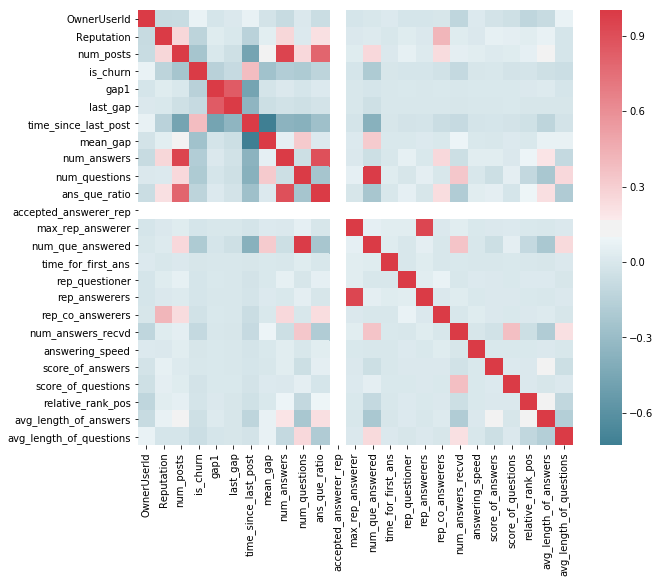

In [195]:
# #Figure correlation of Task2

# import seaborn as sns
# from google.colab import files

# # for T in list_of_T:

# f, ax = plt.subplots(figsize=(10,8))
# corr=features_of_task2[7].corr()
# sns.heatmap(corr, mask=np.zeros_like(corr,dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
#           square=True, ax=ax)
# plt.savefig('task2_{}days_corr.png'.format(7))
# files.download('task2_{}days_corr.png'.format(7))
# #   plt.matshow(features_of_task2[T].corr())
# #   plt.show()

In [234]:
task2_corr=features_of_task2[7].corr()
task2_corr
drop_criteria = 0.9
drop_feature_list =[]
to_save=[]
for i, j in task2_corr.iterrows():
    for col_i, col_v in enumerate(list(task2_corr.columns)):
      if not i== col_v :
        if  abs(j[col_i]) >drop_criteria:
          if i not in to_save and col_v not in to_save:
            to_save.append(i)
            drop_feature_list.append(col_v)
          elif i in to_save:
            drop_feature_list.append(col_v)
          elif col_v in to_save:
            drop_feature_list.append(i)
#           drop_feature_list.append(col_v)

          
print(drop_feature_list)      
print(to_save)
drop_feature_list= list(set(drop_feature_list))
print(drop_feature_list)      

['num_answers', 'num_answers', 'num_que_answered', 'rep_answerers', 'num_que_answered', 'rep_answerers']
['num_posts', 'num_questions', 'max_rep_answerer']
['num_que_answered', 'rep_answerers', 'num_answers']


In [235]:
# Table 3: Performance on Task 2 after additional feature deletion
# models = [DecisionTreeClassifier, LogisticRegression_, SVC_rbf, SVC_linear]
# modelnames=['DT','LR']
task2_acc_df=pd.DataFrame(columns=['DTmean','DTvar','LRmean','LRvar'])
drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate'] + drop_feature_list
print(drop_user_columns)
# model = LogisticRegression_
# model = DecisionTreeClassifier
# models = [SVC_rbf, SVC_linear, DecisionTreeClassifier, LogisticRegression_]
models = [DecisionTreeClassifier, LogisticRegression_]
for i in range(len(models)):
  model  = models[i]
  for T in list_of_T:
      stime=time.time()
      print('Task 2, T={0}, start : {1}'.format(T, stime))
      train_features = [col for col in features_of_task2[T].columns 
                        if col not in drop_user_columns + ['is_churn']]

      acc_list = learn_model(features_of_task2[T], train_features, model=model)
      task2_acc_df.set_value(T,modelname[i]+'mean',np.mean(acc_list))
      task2_acc_df.set_value(T,modelname[i]+'var',np.var(acc_list))
      print('Accuracy: {} VAR : {}'.format(np.mean(acc_list), np.var(acc_list)))
      print('    for each folds: {}'.format(acc_list))
      print('end : {0}, execution time : {1}'.format(time.time(), time.time()-stime))


['Reputation', 'CreationDate', 'LastAccessDate', 'num_que_answered', 'rep_answerers', 'num_answers']
Task 2, T=7, start : 1571816325.3648717
DecisionTreeClassifier
churn : 245574, stay : 149035
after sampling : churn : 149035, stay : 149035
churn : 245730, stay : 148879
after sampling : churn : 148879, stay : 148879
churn : 245603, stay : 149006
after sampling : churn : 149006, stay : 149006
churn : 245685, stay : 148924
after sampling : churn : 148924, stay : 148924
churn : 245654, stay : 148955
after sampling : churn : 148955, stay : 148955
churn : 245400, stay : 149210
after sampling : churn : 149210, stay : 149210
churn : 245573, stay : 149037
after sampling : churn : 149037, stay : 149037
churn : 245656, stay : 148954
after sampling : churn : 148954, stay : 148954
churn : 245383, stay : 149227
after sampling : churn : 149227, stay : 149227
churn : 245536, stay : 149074
after sampling : churn : 149074, stay : 149074


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 61.94866014921017 VAR : 0.024433868113494135
    for each folds: [62.247411394425946, 61.818637960133195, 62.128814487068375, 61.78442731378005, 61.978287643114534, 61.78355570760634, 62.05952788231269, 62.03443950279393, 61.80636332535067, 61.84513627551602]
end : 1571816384.0003161, execution time : 58.63544487953186
Task 2, T=15, start : 1571816384.0003614
DecisionTreeClassifier
churn : 261783, stay : 147304
after sampling : churn : 147304, stay : 147304
churn : 261847, stay : 147240
after sampling : churn : 147240, stay : 147240
churn : 261933, stay : 147155
after sampling : churn : 147155, stay : 147155
churn : 261876, stay : 147212
after sampling : churn : 147212, stay : 147212
churn : 262109, stay : 146979
after sampling : churn : 146979, stay : 146979
churn : 261893, stay : 147195
after sampling : churn : 147195, stay : 147195
churn : 261800, stay : 147288
after sampling : churn : 147288, stay : 147288
churn : 261919, stay : 147169
after sampling : churn : 147169, sta

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 63.62998387836335 VAR : 0.025969204003733176
    for each folds: [63.62116378836212, 63.50676493235068, 63.6687640251683, 63.60496325955911, 63.81836582038984, 63.708364500374, 63.21555858670304, 63.76996523958287, 63.71936463237559, 63.666563998767984]
end : 1571816443.5660396, execution time : 59.565678358078
Task 2, T=30, start : 1571816443.5665405
DecisionTreeClassifier
churn : 279873, stay : 144869
after sampling : churn : 144869, stay : 144869
churn : 279906, stay : 144836
after sampling : churn : 144836, stay : 144836
churn : 280010, stay : 144732
after sampling : churn : 144732, stay : 144732
churn : 280013, stay : 144729
after sampling : churn : 144729, stay : 144729
churn : 280059, stay : 144683
after sampling : churn : 144683, stay : 144683
churn : 280022, stay : 144720
after sampling : churn : 144720, stay : 144720
churn : 279966, stay : 144777
after sampling : churn : 144777, stay : 144777
churn : 279925, stay : 144818
after sampling : churn : 144818, stay : 1448

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 65.17070121063156 VAR : 0.04002690277643323
    for each folds: [65.16930118235369, 65.3282196889435, 65.15658770182651, 64.69042674916302, 65.2413442386744, 65.39178709157943, 64.93547771915327, 65.32324709172971, 65.27874896700781, 65.19187167588413]
end : 1571816512.6082537, execution time : 69.04171347618103
Task 2, T=7, start : 1571816512.6086638
LogisticRegression_
churn : 245574, stay : 149035
after sampling : churn : 149035, stay : 149035


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245730, stay : 148879
after sampling : churn : 148879, stay : 148879


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245603, stay : 149006
after sampling : churn : 149006, stay : 149006


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245685, stay : 148924
after sampling : churn : 148924, stay : 148924


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245654, stay : 148955
after sampling : churn : 148955, stay : 148955


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245400, stay : 149210
after sampling : churn : 149210, stay : 149210


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245573, stay : 149037
after sampling : churn : 149037, stay : 149037


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245656, stay : 148954
after sampling : churn : 148954, stay : 148954


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245383, stay : 149227
after sampling : churn : 149227, stay : 149227


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245536, stay : 149074
after sampling : churn : 149074, stay : 149074


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 69.36356151037282 VAR : 0.019049325465285535
    for each folds: [69.23550608949505, 69.29252383341696, 69.42480499931578, 69.2012954431419, 69.30164667244446, 69.41042308130916, 69.29638499258752, 69.29410423081309, 69.6932375413388, 69.48568821986544]
end : 1571816755.8898897, execution time : 243.2812271118164
Task 2, T=15, start : 1571816755.8900602
LogisticRegression_
churn : 261783, stay : 147304
after sampling : churn : 147304, stay : 147304


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261847, stay : 147240
after sampling : churn : 147240, stay : 147240


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261933, stay : 147155
after sampling : churn : 147155, stay : 147155


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261876, stay : 147212
after sampling : churn : 147212, stay : 147212


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 262109, stay : 146979
after sampling : churn : 146979, stay : 146979


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261893, stay : 147195
after sampling : churn : 147195, stay : 147195


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261800, stay : 147288
after sampling : churn : 147288, stay : 147288


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261919, stay : 147169
after sampling : churn : 147169, stay : 147169


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261877, stay : 147211
after sampling : churn : 147211, stay : 147211


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261891, stay : 147197
after sampling : churn : 147197, stay : 147197


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 72.76687250243702 VAR : 0.02848756352902569
    for each folds: [72.87647123528765, 72.89627103728962, 72.83627403528843, 72.4666696000352, 72.58547102565231, 72.91767501210015, 72.78787345448146, 72.53047036564439, 72.78347340168082, 72.98807585691029]
end : 1571816991.2906363, execution time : 235.40057635307312
Task 2, T=30, start : 1571816991.2909086
LogisticRegression_
churn : 279873, stay : 144869
after sampling : churn : 144869, stay : 144869


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 279906, stay : 144836
after sampling : churn : 144836, stay : 144836


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 280010, stay : 144732
after sampling : churn : 144732, stay : 144732


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 280013, stay : 144729
after sampling : churn : 144729, stay : 144729


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 280059, stay : 144683
after sampling : churn : 144683, stay : 144683


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 280022, stay : 144720
after sampling : churn : 144720, stay : 144720


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 279966, stay : 144777
after sampling : churn : 144777, stay : 144777


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 279925, stay : 144818
after sampling : churn : 144818, stay : 144818


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 280031, stay : 144712
after sampling : churn : 144712, stay : 144712


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 280086, stay : 144657
after sampling : churn : 144657, stay : 144657
Accuracy: 75.27376621815448 VAR : 0.01709920225233514
    for each folds: [75.41000974700174, 75.38670169936856, 75.04343772513455, 75.07945925329491, 75.34432343094461, 75.24473450014833, 75.401012862077, 75.24844786303053, 75.40313182039709, 75.17640328014748]
end : 1571817232.3595898, execution time : 241.06868529319763


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [0]:
from google.colab import files

In [0]:
task2_acc_df.to_csv('afterFeatureDeletion_task2_accuracy.csv')
files.download('afterFeatureDeletion_task2_accuracy.csv')

In [242]:
task1_corr=features_of_task1[7].corr()
task1_corr
drop_criteria = 0.9
drop_feature_list =[]
to_save=[]
for i, j in task1_corr.iterrows():
    for col_i, col_v in enumerate(list(task1_corr.columns)):
      if not i== col_v :
        if  abs(j[col_i]) >drop_criteria:
          if i not in to_save and col_v not in to_save:
            to_save.append(i)
            drop_feature_list.append(col_v)
          elif i in to_save:
            drop_feature_list.append(col_v)
          elif col_v in to_save:
            drop_feature_list.append(i)
#           drop_feature_list.append(col_v)

          
print(drop_feature_list)      
print(to_save)
drop_feature_list= list(set(drop_feature_list))
print(drop_feature_list)      

['num_questions', 'num_que_answered', 'num_questions', 'num_que_answered', 'num_que_answered', 'num_que_answered']
['num_answers', 'num_questions']
['num_que_answered', 'num_questions']


In [243]:
# Table 2: Performance on Task 1 after feature reduction

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate', 'num_posts'] + drop_feature_list
models=[ DecisionTreeClassifier, LogisticRegression_]
modelname=['DT','LR']
# models = [SVC_rbf, SVC_linear, DecisionTreeClassifier, LogisticRegression_]
# models = [LogisticRegression_, SVC]
for i in range(len(models)):
# for i in range(2):
# i=1
  model = models[i]
  for K in list_of_K:
    stime = time.time()
    print('Task 1,model={}, K={}, start : {}'.format(i,K, stime))
    train_features = [col for col in features_of_task1[K].columns 
                      if col not in drop_user_columns + ['is_churn']]
    acc_list = learn_model(features_of_task1[K], train_features, model=model)
    acc_df.set_value(K,modelname[i]+ ' mean',np.mean(acc_list))
    acc_df.set_value(K,modelname[i]+ ' var',np.var(acc_list))

    print('Accuracy: {}, VAR : {} '.format(np.mean(acc_list), np.var(acc_list)))
    print('    for each folds: {}'.format(acc_list))
    print('end : {0}, execution time : {1}'.format(time.time(), time.time()-stime))


Task 1,model=0, K=1, start : 1571817861.9402022
DecisionTreeClassifier
churn : 252584, stay : 264306
after sampling : churn : 252584, stay : 252584
churn : 252648, stay : 264242
after sampling : churn : 252648, stay : 252648
churn : 252780, stay : 264110
after sampling : churn : 252780, stay : 252780
churn : 252633, stay : 264258
after sampling : churn : 252633, stay : 252633
churn : 252670, stay : 264221
after sampling : churn : 252670, stay : 252670
churn : 252633, stay : 264258
after sampling : churn : 252633, stay : 252633
churn : 252822, stay : 264069
after sampling : churn : 252822, stay : 252822
churn : 252661, stay : 264230
after sampling : churn : 252661, stay : 252661
churn : 252412, stay : 264479
after sampling : churn : 252412, stay : 252412
churn : 252682, stay : 264209
after sampling : churn : 252682, stay : 252682


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 58.574354990048825, VAR : 0.05874771384743105 
    for each folds: [58.66313791722529, 58.92257064753713, 58.85640659551129, 58.563170357988575, 58.67983005989692, 58.279356456330966, 58.66415935367043, 58.056484189998606, 58.538793703858474, 58.51964061847054]
end : 1571817946.8514085, execution time : 84.91120672225952
Task 1,model=0, K=2, start : 1571817946.851496
DecisionTreeClassifier
churn : 82696, stay : 211181
after sampling : churn : 82696, stay : 82696
churn : 82744, stay : 211133
after sampling : churn : 82744, stay : 82744
churn : 82703, stay : 211174
after sampling : churn : 82703, stay : 82703
churn : 82718, stay : 211159
after sampling : churn : 82718, stay : 82718
churn : 82643, stay : 211234
after sampling : churn : 82643, stay : 82643
churn : 82644, stay : 211233
after sampling : churn : 82644, stay : 82644
churn : 82820, stay : 211057
after sampling : churn : 82820, stay : 82820
churn : 82915, stay : 210962
after sampling : churn : 82915, stay : 82915
churn

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 56.522830980308086, VAR : 0.03700967800491266 
    for each folds: [56.60123112730837, 56.328668116252715, 56.50016843781582, 56.74823140293388, 56.546106023948795, 56.331730621994915, 56.8952316785594, 56.252105472697764, 56.39910574832328, 56.62573117324595]
end : 1571817981.433067, execution time : 34.58157157897949
Task 1,model=0, K=3, start : 1571817981.4331043
DecisionTreeClassifier
churn : 45826, stay : 182099
after sampling : churn : 45826, stay : 45826
churn : 45964, stay : 181962
after sampling : churn : 45964, stay : 45964
churn : 45845, stay : 182081
after sampling : churn : 45845, stay : 45845
churn : 45905, stay : 182021
after sampling : churn : 45905, stay : 45905
churn : 45809, stay : 182117
after sampling : churn : 45809, stay : 45809
churn : 45912, stay : 182014
after sampling : churn : 45912, stay : 45912
churn : 45824, stay : 182102
after sampling : churn : 45824, stay : 45824
churn : 45854, stay : 182072
after sampling : churn : 45854, stay : 45854
churn 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 57.790886586201225, VAR : 0.060336111359252764 
    for each folds: [57.97204453920872, 57.737413622902274, 58.24284304047384, 58.12043435340573, 57.79269496544916, 57.425468904244816, 57.48864758144126, 57.776900296150046, 57.717670286278384, 57.63474827245805]
end : 1571818003.7776287, execution time : 22.34452486038208
Task 1,model=0, K=4, start : 1571818003.7776875
DecisionTreeClassifier
churn : 32007, stay : 160857
after sampling : churn : 32007, stay : 32007
churn : 31975, stay : 160889
after sampling : churn : 31975, stay : 31975
churn : 31964, stay : 160900
after sampling : churn : 31964, stay : 31964
churn : 31949, stay : 160915
after sampling : churn : 31949, stay : 31949
churn : 31914, stay : 160951
after sampling : churn : 31914, stay : 31914
churn : 31963, stay : 160902
after sampling : churn : 31963, stay : 31963
churn : 31955, stay : 160910
after sampling : churn : 31955, stay : 31955
churn : 32000, stay : 160865
after sampling : churn : 32000, stay : 32000
chu

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 58.71933093924838, VAR : 0.08803237813769584 
    for each folds: [59.043397106859544, 58.866075594960336, 58.01213252449837, 58.65142323845077, 58.584161650100334, 58.78949087684913, 58.551495636753934, 58.75682486350273, 58.78015773017873, 59.158150170329925]
end : 1571818020.8375762, execution time : 17.05988883972168
Task 1,model=0, K=5, start : 1571818020.8380086
DecisionTreeClassifier
churn : 23619, stay : 145476
after sampling : churn : 23619, stay : 23619
churn : 23709, stay : 145386
after sampling : churn : 23709, stay : 23709
churn : 23757, stay : 145338
after sampling : churn : 23757, stay : 23757
churn : 23699, stay : 145396
after sampling : churn : 23699, stay : 23699
churn : 23672, stay : 145424
after sampling : churn : 23672, stay : 23672
churn : 23798, stay : 145298
after sampling : churn : 23798, stay : 23798
churn : 23685, stay : 145411
after sampling : churn : 23685, stay : 23685
churn : 23646, stay : 145450
after sampling : churn : 23646, stay : 23646
chur

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.044498373763666, VAR : 0.1543371927534037 
    for each folds: [59.35387726861462, 59.96061525360583, 59.9286816754484, 60.40236308478365, 60.49606131573345, 59.45816478603364, 59.92654886097509, 60.53331913987652, 60.001064509261234, 60.384287843304236]
end : 1571818034.4373906, execution time : 13.599382162094116
Task 1,model=0, K=6, start : 1571818034.4379356
DecisionTreeClassifier
churn : 18630, stay : 132907
after sampling : churn : 18630, stay : 18630
churn : 18554, stay : 132983
after sampling : churn : 18554, stay : 18554
churn : 18644, stay : 132893
after sampling : churn : 18644, stay : 18644
churn : 18581, stay : 132956
after sampling : churn : 18581, stay : 18581
churn : 18585, stay : 132952
after sampling : churn : 18585, stay : 18585
churn : 18642, stay : 132896
after sampling : churn : 18642, stay : 18642
churn : 18633, stay : 132905
after sampling : churn : 18633, stay : 18633
churn : 18631, stay : 132907
after sampling : churn : 18631, stay : 18631
churn :

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.95441018729904, VAR : 0.21599016900426787 
    for each folds: [61.806627865542225, 61.0880152037059, 61.34338995130063, 60.57726570851645, 61.141465732272245, 60.723406782681, 60.21262695254499, 61.43612282473125, 60.68183168022807, 60.5333491714676]
end : 1571818045.7503238, execution time : 11.31238842010498
Task 1,model=0, K=7, start : 1571818045.7503974
DecisionTreeClassifier
churn : 15303, stay : 122654
after sampling : churn : 15303, stay : 15303
churn : 15314, stay : 122643
after sampling : churn : 15314, stay : 15314
churn : 15257, stay : 122700
after sampling : churn : 15257, stay : 15257
churn : 15200, stay : 122757
after sampling : churn : 15200, stay : 15200
churn : 15262, stay : 122695
after sampling : churn : 15262, stay : 15262
churn : 15298, stay : 122659
after sampling : churn : 15298, stay : 15298
churn : 15276, stay : 122682
after sampling : churn : 15276, stay : 15276
churn : 15273, stay : 122685
after sampling : churn : 15273, stay : 15273
churn : 152

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 61.9723857099626, VAR : 0.08684613564170701 
    for each folds: [61.77180507534738, 62.208885119707745, 62.28064452997586, 61.85008806836715, 62.365451105747276, 62.24150303346598, 61.50835073068894, 61.82150313152401, 61.55401878914405, 62.12160751565762]
end : 1571818055.4061112, execution time : 9.655714273452759
Task 1,model=0, K=8, start : 1571818055.406326
DecisionTreeClassifier
churn : 12921, stay : 113817
after sampling : churn : 12921, stay : 12921
churn : 12917, stay : 113821
after sampling : churn : 12917, stay : 12917
churn : 12890, stay : 113848
after sampling : churn : 12890, stay : 12890
churn : 12954, stay : 113784
after sampling : churn : 12954, stay : 12954
churn : 12883, stay : 113855
after sampling : churn : 12883, stay : 12883
churn : 12897, stay : 113841
after sampling : churn : 12897, stay : 12897
churn : 12962, stay : 113776
after sampling : churn : 12962, stay : 12962
churn : 12984, stay : 113754
after sampling : churn : 12984, stay : 12984
churn : 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 62.831273966766084, VAR : 0.2887045565748269 
    for each folds: [64.04630024144298, 63.10893339014345, 62.05084505041897, 62.66155375656867, 63.42849027126829, 62.675756284618664, 62.47692089191876, 62.46981962789376, 62.590541116318704, 62.8035790370686]
end : 1571818064.1373615, execution time : 8.731035947799683
Task 1,model=0, K=9, start : 1571818064.1378186
DecisionTreeClassifier
churn : 10996, stay : 106382
after sampling : churn : 10996, stay : 10996
churn : 10929, stay : 106450
after sampling : churn : 10929, stay : 10929
churn : 10913, stay : 106466
after sampling : churn : 10913, stay : 10913
churn : 10932, stay : 106447
after sampling : churn : 10932, stay : 10932
churn : 10949, stay : 106430
after sampling : churn : 10949, stay : 10949
churn : 10902, stay : 106477
after sampling : churn : 10902, stay : 10902
churn : 10958, stay : 106421
after sampling : churn : 10958, stay : 10958
churn : 10890, stay : 106489
after sampling : churn : 10890, stay : 10890
churn : 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 63.300387346053625, VAR : 0.10602158400868004 
    for each folds: [63.482327685348466, 62.9504677196749, 63.249501610182485, 62.95813525532894, 63.694218678116854, 64.03159024689465, 63.25716914583653, 63.165158717988035, 63.08848336144763, 63.12682103971783]
end : 1571818071.77237, execution time : 7.634551763534546
Task 1,model=0, K=10, start : 1571818071.7724147
DecisionTreeClassifier
churn : 9334, stay : 100155
after sampling : churn : 9334, stay : 9334
churn : 9304, stay : 100185
after sampling : churn : 9304, stay : 9304
churn : 9359, stay : 100130
after sampling : churn : 9359, stay : 9359
churn : 9401, stay : 100088
after sampling : churn : 9401, stay : 9401
churn : 9401, stay : 100088
after sampling : churn : 9401, stay : 9401
churn : 9372, stay : 100118
after sampling : churn : 9372, stay : 9372
churn : 9367, stay : 100123
after sampling : churn : 9367, stay : 9367
churn : 9322, stay : 100168
after sampling : churn : 9322, stay : 9322
churn : 9342, stay : 100148
af

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 63.76965830737545, VAR : 0.26809536114804416 
    for each folds: [64.0309058030577, 64.09666283084005, 64.01446654611212, 64.35969094196942, 64.56518165378925, 63.01685162351007, 63.10727496917386, 63.90464447184546, 63.32100287710645, 63.27990135635019]
end : 1571818078.578608, execution time : 6.806193590164185
Task 1,model=0, K=11, start : 1571818078.5786593
DecisionTreeClassifier
churn : 8214, stay : 94565
after sampling : churn : 8214, stay : 8214
churn : 8237, stay : 94542
after sampling : churn : 8237, stay : 8237
churn : 8228, stay : 94551
after sampling : churn : 8228, stay : 8228
churn : 8168, stay : 94611
after sampling : churn : 8168, stay : 8168
churn : 8204, stay : 94575
after sampling : churn : 8204, stay : 8204
churn : 8196, stay : 94583
after sampling : churn : 8196, stay : 8196
churn : 8195, stay : 94584
after sampling : churn : 8195, stay : 8195
churn : 8206, stay : 94573
after sampling : churn : 8206, stay : 8206
churn : 8169, stay : 94610
after sampling 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 64.59863664715873, VAR : 0.10065770931589095 
    for each folds: [64.57092819614711, 64.95621716287215, 64.82486865148861, 64.67600700525394, 64.57968476357269, 65.00875656742556, 64.20315236427321, 64.01050788091068, 64.85113835376532, 64.30510552587792]
end : 1571818084.9713025, execution time : 6.392643451690674
Task 1,model=0, K=12, start : 1571818084.9713557
DecisionTreeClassifier
churn : 7241, stay : 89547
after sampling : churn : 7241, stay : 7241
churn : 7234, stay : 89554
after sampling : churn : 7234, stay : 7234
churn : 7246, stay : 89542
after sampling : churn : 7246, stay : 7246
churn : 7272, stay : 89517
after sampling : churn : 7272, stay : 7272
churn : 7226, stay : 89563
after sampling : churn : 7226, stay : 7226
churn : 7231, stay : 89558
after sampling : churn : 7231, stay : 7231
churn : 7197, stay : 89592
after sampling : churn : 7197, stay : 7197
churn : 7221, stay : 89568
after sampling : churn : 7221, stay : 7221
churn : 7255, stay : 89534
after samplin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 65.19067101149781, VAR : 0.3657366857683315 
    for each folds: [65.35564853556485, 65.10460251046025, 64.77917247791724, 66.01264645713223, 64.66431095406361, 65.20364515529106, 64.74800074390924, 66.37530221313, 64.26445973591221, 65.39892133159755]
end : 1571818090.7002242, execution time : 5.728869199752808
Task 1,model=0, K=13, start : 1571818090.7002778
DecisionTreeClassifier
churn : 6375, stay : 85163
after sampling : churn : 6375, stay : 6375
churn : 6456, stay : 85082
after sampling : churn : 6456, stay : 6456
churn : 6437, stay : 85101
after sampling : churn : 6437, stay : 6437
churn : 6433, stay : 85105
after sampling : churn : 6433, stay : 6433
churn : 6430, stay : 85108
after sampling : churn : 6430, stay : 6430
churn : 6455, stay : 85083
after sampling : churn : 6455, stay : 6455
churn : 6421, stay : 85117
after sampling : churn : 6421, stay : 6421
churn : 6431, stay : 85107
after sampling : churn : 6431, stay : 6431
churn : 6401, stay : 85137
after sampling : 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 65.69133896892151, VAR : 0.8404811167209234 
    for each folds: [65.69658833939633, 67.34834332907286, 65.66709271458068, 64.31029397306067, 65.99154458755285, 65.76541146396617, 65.66709271458068, 63.966178350211386, 66.41431520991053, 66.08652900688298]
end : 1571818096.0755332, execution time : 5.375255346298218
Task 1,model=0, K=14, start : 1571818096.0755544
DecisionTreeClassifier
churn : 5766, stay : 81148
after sampling : churn : 5766, stay : 5766
churn : 5781, stay : 81133
after sampling : churn : 5781, stay : 5781
churn : 5746, stay : 81169
after sampling : churn : 5746, stay : 5746
churn : 5758, stay : 81157
after sampling : churn : 5758, stay : 5758
churn : 5774, stay : 81141
after sampling : churn : 5774, stay : 5774
churn : 5741, stay : 81174
after sampling : churn : 5741, stay : 5741
churn : 5747, stay : 81168
after sampling : churn : 5747, stay : 5747
churn : 5775, stay : 81140
after sampling : churn : 5775, stay : 5775
churn : 5741, stay : 81174
after samplin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 66.75227319206581, VAR : 0.16927500293391026 
    for each folds: [65.94533029612757, 67.03251190722717, 66.25245935590763, 66.54240447343895, 67.14300507403955, 67.16371543957752, 67.26726726726727, 66.50098374236305, 66.88412550481516, 66.79092885989438]
end : 1571818101.0553684, execution time : 4.979814529418945
Task 1,model=0, K=15, start : 1571818101.0554132
DecisionTreeClassifier
churn : 5083, stay : 77609
after sampling : churn : 5083, stay : 5083
churn : 5114, stay : 77579
after sampling : churn : 5114, stay : 5114
churn : 5092, stay : 77601
after sampling : churn : 5092, stay : 5092
churn : 5086, stay : 77607
after sampling : churn : 5086, stay : 5086
churn : 5078, stay : 77615
after sampling : churn : 5078, stay : 5078
churn : 5102, stay : 77591
after sampling : churn : 5102, stay : 5102
churn : 5129, stay : 77564
after sampling : churn : 5129, stay : 5129
churn : 5077, stay : 77616
after sampling : churn : 5077, stay : 5077
churn : 5092, stay : 77601
after samplin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 67.24022620694151, VAR : 0.6247798987448572 
    for each folds: [68.01610621395146, 67.38136700043535, 66.44536351763169, 67.2834131475838, 65.75968654767088, 66.27122333478451, 67.5446234218546, 67.3487157161515, 68.12146277753591, 68.2303003918154]
end : 1571818105.4216824, execution time : 4.36626935005188
Task 1,model=0, K=16, start : 1571818105.4217162
DecisionTreeClassifier
churn : 4636, stay : 74342
after sampling : churn : 4636, stay : 4636
churn : 4659, stay : 74319
after sampling : churn : 4659, stay : 4659
churn : 4630, stay : 74348
after sampling : churn : 4630, stay : 4630
churn : 4650, stay : 74328
after sampling : churn : 4650, stay : 4650
churn : 4714, stay : 74265
after sampling : churn : 4714, stay : 4714
churn : 4669, stay : 74310
after sampling : churn : 4669, stay : 4669
churn : 4638, stay : 74341
after sampling : churn : 4638, stay : 4638
churn : 4641, stay : 74338
after sampling : churn : 4641, stay : 4641
churn : 4675, stay : 74304
after sampling : ch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 67.30403924715685, VAR : 0.4600839717984503 
    for each folds: [67.46809480401095, 67.80993618960802, 68.04922515952597, 67.22880583409298, 66.5071225071225, 65.78917378917379, 67.93162393162393, 67.76068376068376, 67.57834757834758, 66.91737891737891]
end : 1571818109.720284, execution time : 4.2985680103302
Task 1,model=0, K=17, start : 1571818109.7210553
DecisionTreeClassifier
churn : 4297, stay : 71274
after sampling : churn : 4297, stay : 4297
churn : 4272, stay : 71299
after sampling : churn : 4272, stay : 4272
churn : 4291, stay : 71280
after sampling : churn : 4291, stay : 4291
churn : 4255, stay : 71316
after sampling : churn : 4255, stay : 4255
churn : 4285, stay : 71286
after sampling : churn : 4285, stay : 4285
churn : 4264, stay : 71307
after sampling : churn : 4264, stay : 4264
churn : 4263, stay : 71308
after sampling : churn : 4263, stay : 4263
churn : 4275, stay : 71296
after sampling : churn : 4275, stay : 4275
churn : 4292, stay : 71280
after sampling : c

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 67.02553595816195, VAR : 0.2245993420200026 
    for each folds: [66.55948553054662, 66.2379421221865, 67.36929855900917, 66.38085030367989, 67.04775515064904, 67.75038704299155, 67.22639037751578, 67.42884363463142, 67.37732253454026, 66.87708432586946]
end : 1571818113.6602068, execution time : 3.9391517639160156
Task 1,model=0, K=18, start : 1571818113.6602402
DecisionTreeClassifier
churn : 3880, stay : 68574
after sampling : churn : 3880, stay : 3880
churn : 3872, stay : 68582
after sampling : churn : 3872, stay : 3872
churn : 3918, stay : 68536
after sampling : churn : 3918, stay : 3918
churn : 3888, stay : 68566
after sampling : churn : 3888, stay : 3888
churn : 3860, stay : 68594
after sampling : churn : 3860, stay : 3860
churn : 3915, stay : 68540
after sampling : churn : 3915, stay : 3915
churn : 3861, stay : 68594
after sampling : churn : 3861, stay : 3861
churn : 3871, stay : 68584
after sampling : churn : 3871, stay : 3871
churn : 3904, stay : 68551
after sampling

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 68.21686037226964, VAR : 0.6275656025771812 
    for each folds: [68.15302446901006, 67.95429139237362, 69.04732331387406, 69.17153148677183, 68.41386163209539, 66.80745341614907, 67.19254658385093, 67.67701863354037, 68.4472049689441, 69.30434782608695]
end : 1571818117.3521383, execution time : 3.6918983459472656
Task 1,model=0, K=19, start : 1571818117.352175
DecisionTreeClassifier
churn : 3579, stay : 65989
after sampling : churn : 3579, stay : 3579
churn : 3573, stay : 65995
after sampling : churn : 3573, stay : 3573
churn : 3599, stay : 65969
after sampling : churn : 3599, stay : 3599
churn : 3579, stay : 65989
after sampling : churn : 3579, stay : 3579
churn : 3582, stay : 65986
after sampling : churn : 3582, stay : 3582
churn : 3580, stay : 65988
after sampling : churn : 3580, stay : 3580
churn : 3585, stay : 65983
after sampling : churn : 3585, stay : 3585
churn : 3616, stay : 65952
after sampling : churn : 3616, stay : 3616
churn : 3616, stay : 65953
after sampling 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 68.28120013718264, VAR : 0.4150039978352759 
    for each folds: [69.00388098318241, 68.0595084087969, 68.83570504527813, 68.82276843467011, 67.64553686934023, 67.78783958602845, 67.4385510996119, 68.44760672703751, 69.27157458920946, 67.49902962867124]
end : 1571818120.7713997, execution time : 3.4192252159118652
Task 1,model=0, K=20, start : 1571818120.7714653
DecisionTreeClassifier
churn : 3383, stay : 63559
after sampling : churn : 3383, stay : 3383
churn : 3393, stay : 63550
after sampling : churn : 3393, stay : 3393
churn : 3335, stay : 63608
after sampling : churn : 3335, stay : 3335
churn : 3394, stay : 63549
after sampling : churn : 3394, stay : 3394
churn : 3349, stay : 63594
after sampling : churn : 3349, stay : 3349
churn : 3352, stay : 63591
after sampling : churn : 3352, stay : 3352
churn : 3367, stay : 63576
after sampling : churn : 3367, stay : 3367
churn : 3349, stay : 63594
after sampling : churn : 3349, stay : 3349
churn : 3327, stay : 63616
after sampling 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 65.23440844909395, VAR : 0.3268157070782192 
    for each folds: [64.69955639198817, 64.41247647216994, 65.39392309760689, 65.23258940575424, 65.420812046249, 65.6224791610648, 65.75692390427534, 66.02581339069643, 65.58214573810164, 64.19736488303307]
end : 1571818124.2199128, execution time : 3.4484477043151855
Task 1,model=1, K=1, start : 1571818124.219949
LogisticRegression_
churn : 252584, stay : 264306
after sampling : churn : 252584, stay : 252584


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252648, stay : 264242
after sampling : churn : 252648, stay : 252648


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252780, stay : 264110
after sampling : churn : 252780, stay : 252780


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252633, stay : 264258
after sampling : churn : 252633, stay : 252633


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252670, stay : 264221
after sampling : churn : 252670, stay : 252670


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252633, stay : 264258
after sampling : churn : 252633, stay : 252633


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252822, stay : 264069
after sampling : churn : 252822, stay : 252822


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252661, stay : 264230
after sampling : churn : 252661, stay : 252661


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252412, stay : 264479
after sampling : churn : 252412, stay : 252412


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 252682, stay : 264209
after sampling : churn : 252682, stay : 252682


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 51.98520738229117, VAR : 0.03888860922492578 
    for each folds: [51.94574547733881, 52.03802691832222, 51.71243013598454, 52.20260481961276, 51.92227329711659, 52.00759158657195, 51.76208385569021, 51.92923805543948, 52.430700654687286, 51.90137902214793]
end : 1571818580.9969635, execution time : 456.7770149707794
Task 1,model=1, K=2, start : 1571818580.99704
LogisticRegression_
churn : 82696, stay : 211181
after sampling : churn : 82696, stay : 82696


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82744, stay : 211133
after sampling : churn : 82744, stay : 82744


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82703, stay : 211174
after sampling : churn : 82703, stay : 82703


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82718, stay : 211159
after sampling : churn : 82718, stay : 82718


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82643, stay : 211234
after sampling : churn : 82643, stay : 82643


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82644, stay : 211233
after sampling : churn : 82644, stay : 82644


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82820, stay : 211057
after sampling : churn : 82820, stay : 82820


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82915, stay : 210962
after sampling : churn : 82915, stay : 82915


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82731, stay : 211146
after sampling : churn : 82731, stay : 82731


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 82738, stay : 211139
after sampling : churn : 82738, stay : 82738


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 40.5004134382752, VAR : 5.699945103836598 
    for each folds: [38.13738400759502, 38.5171347196276, 41.01001439377699, 39.15719841974704, 39.11432333935626, 39.36238630447432, 40.41282577404833, 46.90840045325085, 40.896701681315655, 41.48776528955992]
end : 1571818704.6011617, execution time : 123.60412192344666
Task 1,model=1, K=3, start : 1571818704.6013415
LogisticRegression_
churn : 45826, stay : 182099
after sampling : churn : 45826, stay : 45826


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45964, stay : 181962
after sampling : churn : 45964, stay : 45964


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45845, stay : 182081
after sampling : churn : 45845, stay : 45845


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45905, stay : 182021
after sampling : churn : 45905, stay : 45905


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45809, stay : 182117
after sampling : churn : 45809, stay : 45809


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45912, stay : 182014
after sampling : churn : 45912, stay : 45912


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45824, stay : 182102
after sampling : churn : 45824, stay : 45824


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45854, stay : 182072
after sampling : churn : 45854, stay : 45854


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45883, stay : 182043
after sampling : churn : 45883, stay : 45883


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 45854, stay : 182072
after sampling : churn : 45854, stay : 45854


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 59.88722410604805, VAR : 0.1189011157058468 
    for each folds: [60.495143330964225, 59.93682132280355, 60.23692003948668, 59.28134254689042, 59.79466929911155, 59.47482724580454, 60.165844027640674, 59.88548864758144, 59.96841066140178, 59.63277393879566]
end : 1571818765.8232734, execution time : 61.22193264961243
Task 1,model=1, K=4, start : 1571818765.823352
LogisticRegression_
churn : 32007, stay : 160857
after sampling : churn : 32007, stay : 32007


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31975, stay : 160889
after sampling : churn : 31975, stay : 31975


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31964, stay : 160900
after sampling : churn : 31964, stay : 31964


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31949, stay : 160915
after sampling : churn : 31949, stay : 31949


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31914, stay : 160951
after sampling : churn : 31914, stay : 31914


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31963, stay : 160902
after sampling : churn : 31963, stay : 31963


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31955, stay : 160910
after sampling : churn : 31955, stay : 31955


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 32000, stay : 160865
after sampling : churn : 32000, stay : 32000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31895, stay : 160970
after sampling : churn : 31895, stay : 31895


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 31887, stay : 160978
after sampling : churn : 31887, stay : 31887


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 61.52015311848064, VAR : 0.255931034288542 
    for each folds: [62.53849743350443, 60.858609426038264, 61.50256649556696, 61.488567428838074, 60.87544915768351, 61.598768024639504, 61.35610621120911, 61.36077278454431, 62.2800877315787, 61.34210649120351]
end : 1571818804.3699281, execution time : 38.546576261520386
Task 1,model=1, K=5, start : 1571818804.3699942
LogisticRegression_
churn : 23619, stay : 145476
after sampling : churn : 23619, stay : 23619


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23709, stay : 145386
after sampling : churn : 23709, stay : 23709


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23757, stay : 145338
after sampling : churn : 23757, stay : 23757


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23699, stay : 145396
after sampling : churn : 23699, stay : 23699


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23672, stay : 145424
after sampling : churn : 23672, stay : 23672


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23798, stay : 145298
after sampling : churn : 23798, stay : 23798


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23685, stay : 145411
after sampling : churn : 23685, stay : 23685


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23646, stay : 145450
after sampling : churn : 23646, stay : 23646


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23632, stay : 145464
after sampling : churn : 23632, stay : 23632


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 23672, stay : 145424
after sampling : churn : 23672, stay : 23672


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 61.40597390654322, VAR : 0.2070981333623009 
    for each folds: [61.52536058332003, 61.40827079674278, 62.03629783383895, 60.65250944701687, 60.911219927613374, 61.73089205876091, 60.84202682563338, 61.99701937406856, 61.29976580796253, 61.65637641047477]
end : 1571818832.2684128, execution time : 27.898419618606567
Task 1,model=1, K=6, start : 1571818832.2687774
LogisticRegression_
churn : 18630, stay : 132907
after sampling : churn : 18630, stay : 18630


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18554, stay : 132983
after sampling : churn : 18554, stay : 18554


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18644, stay : 132893
after sampling : churn : 18644, stay : 18644


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18581, stay : 132956
after sampling : churn : 18581, stay : 18581


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18585, stay : 132952
after sampling : churn : 18585, stay : 18585


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18642, stay : 132896
after sampling : churn : 18642, stay : 18642


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18633, stay : 132905
after sampling : churn : 18633, stay : 18633


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18631, stay : 132907
after sampling : churn : 18631, stay : 18631


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18609, stay : 132929
after sampling : churn : 18609, stay : 18609


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 18629, stay : 132909
after sampling : churn : 18629, stay : 18629


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 61.06190679703366, VAR : 0.20297701501902035 
    for each folds: [61.88383418458249, 61.44435206081482, 61.450291008433304, 60.78512887516332, 61.1889773132201, 61.293579616321196, 60.735285383381836, 60.972857397398585, 60.39080596305755, 60.473956167963415]
end : 1571818854.3590648, execution time : 22.090287685394287
Task 1,model=1, K=7, start : 1571818854.359994
LogisticRegression_
churn : 15303, stay : 122654
after sampling : churn : 15303, stay : 15303


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15314, stay : 122643
after sampling : churn : 15314, stay : 15314


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15257, stay : 122700
after sampling : churn : 15257, stay : 15257


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15200, stay : 122757
after sampling : churn : 15200, stay : 15200


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15262, stay : 122695
after sampling : churn : 15262, stay : 15262


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15298, stay : 122659
after sampling : churn : 15298, stay : 15298


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15276, stay : 122682
after sampling : churn : 15276, stay : 15276


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15273, stay : 122685
after sampling : churn : 15273, stay : 15273


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15278, stay : 122680
after sampling : churn : 15278, stay : 15278


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 15215, stay : 122743
after sampling : churn : 15215, stay : 15215


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.38972589001621, VAR : 0.21486421069240755 
    for each folds: [60.010437732402636, 60.42142344575641, 60.6823667558223, 61.35429577924196, 60.16048013569052, 60.18657446669711, 60.76461377870564, 60.61456158663883, 60.09916492693111, 59.603340292275576]
end : 1571818872.161721, execution time : 17.801727056503296
Task 1,model=1, K=8, start : 1571818872.1619046
LogisticRegression_
churn : 12921, stay : 113817
after sampling : churn : 12921, stay : 12921


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12917, stay : 113821
after sampling : churn : 12917, stay : 12917


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12890, stay : 113848
after sampling : churn : 12890, stay : 12890


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12954, stay : 113784
after sampling : churn : 12954, stay : 12954


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12883, stay : 113855
after sampling : churn : 12883, stay : 12883


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12897, stay : 113841
after sampling : churn : 12897, stay : 12897


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12962, stay : 113776
after sampling : churn : 12962, stay : 12962


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12984, stay : 113754
after sampling : churn : 12984, stay : 12984


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12880, stay : 113858
after sampling : churn : 12880, stay : 12880


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 12934, stay : 113804
after sampling : churn : 12934, stay : 12934


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.948728873739526, VAR : 0.35018984408908144 
    for each folds: [61.248402215594375, 61.08507314301946, 60.18321261184491, 60.431756852719786, 60.524073285044736, 61.95852861809402, 60.70870614969465, 61.93012356199404, 60.3891492685698, 61.02826303081949]
end : 1571818886.9582229, execution time : 14.796319007873535
Task 1,model=1, K=9, start : 1571818886.958299
LogisticRegression_
churn : 10996, stay : 106382
after sampling : churn : 10996, stay : 10996


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10929, stay : 106450
after sampling : churn : 10929, stay : 10929


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10913, stay : 106466
after sampling : churn : 10913, stay : 10913


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10932, stay : 106447
after sampling : churn : 10932, stay : 10932


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10949, stay : 106430
after sampling : churn : 10949, stay : 10949


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10902, stay : 106477
after sampling : churn : 10902, stay : 10902


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10958, stay : 106421
after sampling : churn : 10958, stay : 10958


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10890, stay : 106489
after sampling : churn : 10890, stay : 10890


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10923, stay : 106456
after sampling : churn : 10923, stay : 10923


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 10949, stay : 106430
after sampling : churn : 10949, stay : 10949


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.47569848557382, VAR : 0.49190466367055696 
    for each folds: [59.403511462086946, 61.163931912283395, 60.243827633798496, 60.328170525992945, 59.82978070848029, 61.64698665848796, 60.35117313295507, 59.77610795890201, 61.43229566017482, 60.58119920257629]
end : 1571818899.5790496, execution time : 12.62075138092041
Task 1,model=1, K=10, start : 1571818899.579136
LogisticRegression_
churn : 9334, stay : 100155
after sampling : churn : 9334, stay : 9334


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9304, stay : 100185
after sampling : churn : 9304, stay : 9304


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9359, stay : 100130
after sampling : churn : 9359, stay : 9359


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9401, stay : 100088
after sampling : churn : 9401, stay : 9401


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9401, stay : 100088
after sampling : churn : 9401, stay : 9401


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9372, stay : 100118
after sampling : churn : 9372, stay : 9372


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9367, stay : 100123
after sampling : churn : 9367, stay : 9367


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9322, stay : 100168
after sampling : churn : 9322, stay : 9322


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9342, stay : 100148
after sampling : churn : 9342, stay : 9342


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 9326, stay : 100164
after sampling : churn : 9326, stay : 9326


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 61.49274122008205, VAR : 0.11799770824640173 
    for each folds: [61.89380240013151, 61.655433174420516, 61.14581620910735, 61.532138747328624, 61.80338648693079, 61.035758323057955, 61.27414714344431, 61.043978627209206, 62.0550760378134, 61.4878750513769]
end : 1571818910.354981, execution time : 10.775845289230347
Task 1,model=1, K=11, start : 1571818910.3550446
LogisticRegression_
churn : 8214, stay : 94565
after sampling : churn : 8214, stay : 8214


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8237, stay : 94542
after sampling : churn : 8237, stay : 8237


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8228, stay : 94551
after sampling : churn : 8228, stay : 8228


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8168, stay : 94611
after sampling : churn : 8168, stay : 8168


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8204, stay : 94575
after sampling : churn : 8204, stay : 8204


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8196, stay : 94583
after sampling : churn : 8196, stay : 8196


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8195, stay : 94584
after sampling : churn : 8195, stay : 8195


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8206, stay : 94573
after sampling : churn : 8206, stay : 8206


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8169, stay : 94610
after sampling : churn : 8169, stay : 8169


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 8164, stay : 94616
after sampling : churn : 8164, stay : 8164


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.75184452311561, VAR : 0.291929588581109 
    for each folds: [60.288966725043785, 60.175131348511385, 61.077057793345006, 61.8476357267951, 61.43607705779335, 60.14886164623468, 60.359019264448335, 60.586690017513135, 60.95446584938704, 60.644539802084246]
end : 1571818920.183709, execution time : 9.828664779663086
Task 1,model=1, K=12, start : 1571818920.1839585
LogisticRegression_
churn : 7241, stay : 89547
after sampling : churn : 7241, stay : 7241


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7234, stay : 89554
after sampling : churn : 7234, stay : 7234


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7246, stay : 89542
after sampling : churn : 7246, stay : 7246


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7272, stay : 89517
after sampling : churn : 7272, stay : 7272


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7226, stay : 89563
after sampling : churn : 7226, stay : 7226


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7231, stay : 89558
after sampling : churn : 7231, stay : 7231


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7197, stay : 89592
after sampling : churn : 7197, stay : 7197


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7221, stay : 89568
after sampling : churn : 7221, stay : 7221


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7255, stay : 89534
after sampling : churn : 7255, stay : 7255


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 7255, stay : 89534
after sampling : churn : 7255, stay : 7255


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.318176398657876, VAR : 0.5899133582728782 
    for each folds: [61.08786610878661, 60.725244072524404, 61.49697814969782, 59.791705411939745, 60.61000557931932, 59.32676213501953, 61.223730704854006, 59.57783150455644, 59.35465873163474, 59.98698158824623]
end : 1571818928.6711612, execution time : 8.487202882766724
Task 1,model=1, K=13, start : 1571818928.6713297
LogisticRegression_
churn : 6375, stay : 85163
after sampling : churn : 6375, stay : 6375


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6456, stay : 85082
after sampling : churn : 6456, stay : 6456


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6437, stay : 85101
after sampling : churn : 6437, stay : 6437


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6433, stay : 85105
after sampling : churn : 6433, stay : 6433


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6430, stay : 85108
after sampling : churn : 6430, stay : 6430


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6455, stay : 85083
after sampling : churn : 6455, stay : 6455


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6421, stay : 85117
after sampling : churn : 6421, stay : 6421


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6431, stay : 85107
after sampling : churn : 6431, stay : 6431


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6401, stay : 85137
after sampling : churn : 6401, stay : 6401


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 6448, stay : 85091
after sampling : churn : 6448, stay : 6448


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.008450868709474, VAR : 0.34286463622325664 
    for each folds: [60.682332120735424, 60.49552649690296, 59.96460525022122, 60.25956149837774, 60.407039622456004, 58.56847900894701, 59.71880837675745, 60.367712122701796, 60.08258774948383, 59.537856440511305]
end : 1571818936.3265843, execution time : 7.655255079269409
Task 1,model=1, K=14, start : 1571818936.3266475
LogisticRegression_
churn : 5766, stay : 81148
after sampling : churn : 5766, stay : 5766


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5781, stay : 81133
after sampling : churn : 5781, stay : 5781


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5746, stay : 81169
after sampling : churn : 5746, stay : 5746


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5758, stay : 81157
after sampling : churn : 5758, stay : 5758


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5774, stay : 81141
after sampling : churn : 5774, stay : 5774


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5741, stay : 81174
after sampling : churn : 5741, stay : 5741


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5747, stay : 81168
after sampling : churn : 5747, stay : 5747


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5775, stay : 81140
after sampling : churn : 5775, stay : 5775


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5741, stay : 81174
after sampling : churn : 5741, stay : 5741


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5771, stay : 81144
after sampling : churn : 5771, stay : 5771


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.857178613050095, VAR : 0.4661382313348371 
    for each folds: [61.575895630565334, 60.68544212052185, 61.03344724034379, 61.08522315418867, 59.48016982499741, 60.370715543129336, 61.178419799109456, 61.43729936833385, 60.00828414621518, 61.7168893030962]
end : 1571818943.873114, execution time : 7.546466827392578
Task 1,model=1, K=15, start : 1571818943.873354
LogisticRegression_
churn : 5083, stay : 77609
after sampling : churn : 5083, stay : 5083


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5114, stay : 77579
after sampling : churn : 5114, stay : 5114


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5092, stay : 77601
after sampling : churn : 5092, stay : 5092


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5086, stay : 77607
after sampling : churn : 5086, stay : 5086


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5078, stay : 77615
after sampling : churn : 5078, stay : 5078


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5102, stay : 77591
after sampling : churn : 5102, stay : 5102


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5129, stay : 77564
after sampling : churn : 5129, stay : 5129


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5077, stay : 77616
after sampling : churn : 5077, stay : 5077


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5092, stay : 77601
after sampling : churn : 5092, stay : 5092


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 5069, stay : 77624
after sampling : churn : 5069, stay : 5069


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 59.01437040265014, VAR : 1.7618520483915223 
    for each folds: [59.64740450538687, 57.205050065302565, 57.531562908141055, 60.27427078798433, 57.89072703526339, 59.164127122333475, 61.667392250761864, 59.7191989551589, 59.17501088376143, 57.868959512407486]
end : 1571818950.4918454, execution time : 6.618491888046265
Task 1,model=1, K=16, start : 1571818950.4920208
LogisticRegression_
churn : 4636, stay : 74342
after sampling : churn : 4636, stay : 4636


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4659, stay : 74319
after sampling : churn : 4659, stay : 4659


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4630, stay : 74348
after sampling : churn : 4630, stay : 4630


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4650, stay : 74328
after sampling : churn : 4650, stay : 4650


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4714, stay : 74265
after sampling : churn : 4714, stay : 4714


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4669, stay : 74310
after sampling : churn : 4669, stay : 4669


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4638, stay : 74341
after sampling : churn : 4638, stay : 4638


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4641, stay : 74338
after sampling : churn : 4641, stay : 4641


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4675, stay : 74304
after sampling : churn : 4675, stay : 4675


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4663, stay : 74316
after sampling : churn : 4663, stay : 4663


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 59.4445996203061, VAR : 0.5641412129086146 
    for each folds: [59.73108477666363, 58.62579762989973, 59.047402005469465, 58.979033728350046, 60.433048433048434, 59.71509971509972, 58.41595441595442, 59.36182336182336, 60.96866096866097, 59.168091168091166]
end : 1571818956.5829449, execution time : 6.090924263000488
Task 1,model=1, K=17, start : 1571818956.5830188
LogisticRegression_
churn : 4297, stay : 71274
after sampling : churn : 4297, stay : 4297


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4272, stay : 71299
after sampling : churn : 4272, stay : 4272


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4291, stay : 71280
after sampling : churn : 4291, stay : 4291


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4255, stay : 71316
after sampling : churn : 4255, stay : 4255


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4285, stay : 71286
after sampling : churn : 4285, stay : 4285


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4264, stay : 71307
after sampling : churn : 4264, stay : 4264


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4263, stay : 71308
after sampling : churn : 4263, stay : 4263


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4275, stay : 71296
after sampling : churn : 4275, stay : 4275


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4292, stay : 71280
after sampling : churn : 4292, stay : 4292


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 4283, stay : 71289
after sampling : churn : 4283, stay : 4283


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 57.80658905551866, VAR : 6.117986591955183 
    for each folds: [56.32964153864475, 59.47362153149935, 56.937001309991665, 51.554126473740624, 56.73454805287603, 58.75908062403239, 59.25925925925926, 59.73561986423723, 58.7065269175798, 60.576464983325394]
end : 1571818962.1486473, execution time : 5.565629243850708
Task 1,model=1, K=18, start : 1571818962.1487193
LogisticRegression_
churn : 3880, stay : 68574
after sampling : churn : 3880, stay : 3880


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3872, stay : 68582
after sampling : churn : 3872, stay : 3872


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3918, stay : 68536
after sampling : churn : 3918, stay : 3918


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3888, stay : 68566
after sampling : churn : 3888, stay : 3888


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3860, stay : 68594
after sampling : churn : 3860, stay : 3860


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3915, stay : 68540
after sampling : churn : 3915, stay : 3915


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3861, stay : 68594
after sampling : churn : 3861, stay : 3861


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3871, stay : 68584
after sampling : churn : 3871, stay : 3871


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3904, stay : 68551
after sampling : churn : 3904, stay : 3904


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3866, stay : 68589
after sampling : churn : 3866, stay : 3866


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 58.578980891228355, VAR : 1.0544842820388038 
    for each folds: [60.16643895168302, 59.07340703018259, 56.91218482176127, 58.60141597317104, 57.2848093404546, 59.80124223602485, 58.024844720496894, 59.20496894409938, 57.63975155279503, 59.08074534161491]
end : 1571818967.683164, execution time : 5.534444808959961
Task 1,model=1, K=19, start : 1571818967.683229
LogisticRegression_
churn : 3579, stay : 65989
after sampling : churn : 3579, stay : 3579


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3573, stay : 65995
after sampling : churn : 3573, stay : 3573


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3599, stay : 65969
after sampling : churn : 3599, stay : 3599


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3579, stay : 65989
after sampling : churn : 3579, stay : 3579


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3582, stay : 65986
after sampling : churn : 3582, stay : 3582


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3580, stay : 65988
after sampling : churn : 3580, stay : 3580


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3585, stay : 65983
after sampling : churn : 3585, stay : 3585


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3616, stay : 65952
after sampling : churn : 3616, stay : 3616


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3616, stay : 65953
after sampling : churn : 3616, stay : 3616


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3574, stay : 65995
after sampling : churn : 3574, stay : 3574


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 60.48150988607112, VAR : 0.8913565790508164 
    for each folds: [60.97024579560155, 61.785252263906855, 58.31824062095731, 61.61707632600259, 60.11642949547219, 59.909443725743856, 61.13842173350582, 60.245795601552395, 60.47354120843576, 60.24065208953293]
end : 1571818973.3500743, execution time : 5.666845798492432
Task 1,model=1, K=20, start : 1571818973.3501368
LogisticRegression_
churn : 3383, stay : 63559
after sampling : churn : 3383, stay : 3383


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3393, stay : 63550
after sampling : churn : 3393, stay : 3393


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3335, stay : 63608
after sampling : churn : 3335, stay : 3335


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3394, stay : 63549
after sampling : churn : 3394, stay : 3394


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3349, stay : 63594
after sampling : churn : 3349, stay : 3349


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3352, stay : 63591
after sampling : churn : 3352, stay : 3352


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3367, stay : 63576
after sampling : churn : 3367, stay : 3367


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3349, stay : 63594
after sampling : churn : 3349, stay : 3349


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3327, stay : 63616
after sampling : churn : 3327, stay : 3327


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 3348, stay : 63595
after sampling : churn : 3348, stay : 3348
Accuracy: 57.57250699522922, VAR : 0.3960000895896444 
    for each folds: [56.92969485145853, 57.260016133369184, 58.68513041140091, 58.8061306802904, 57.313794030653405, 57.43479429954289, 57.54235009411132, 57.69023931164291, 56.9911266469481, 57.07179349287443]
end : 1571818977.968187, execution time : 4.618050575256348


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [0]:
from google.colab import files

In [0]:
acc_df.to_csv('afterFeatureDeletion_task1_accuracy.csv')
files.download('afterFeatureDeletion_task1_accuracy.csv')

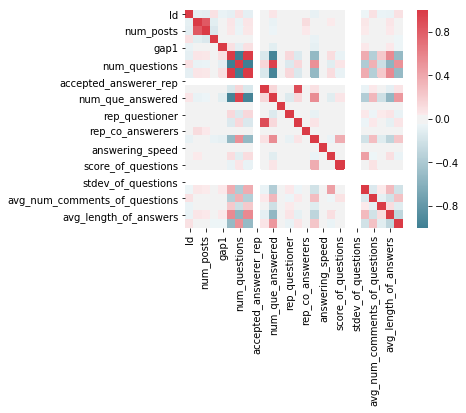

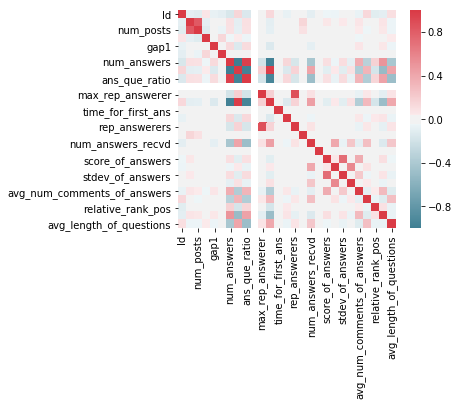

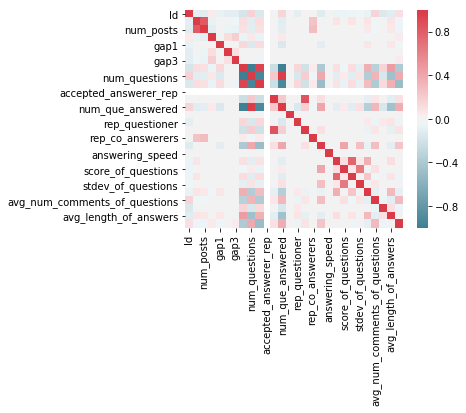

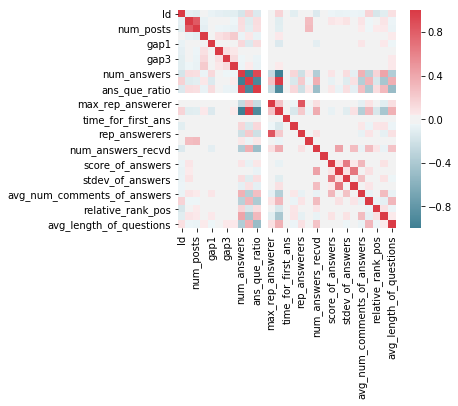

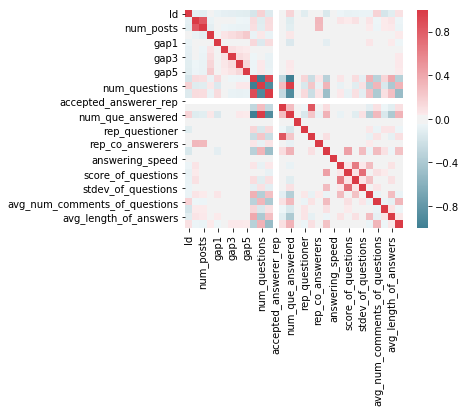

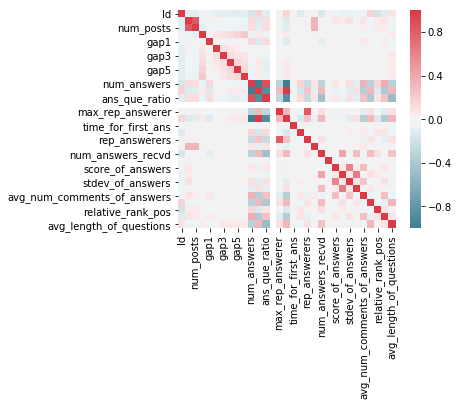

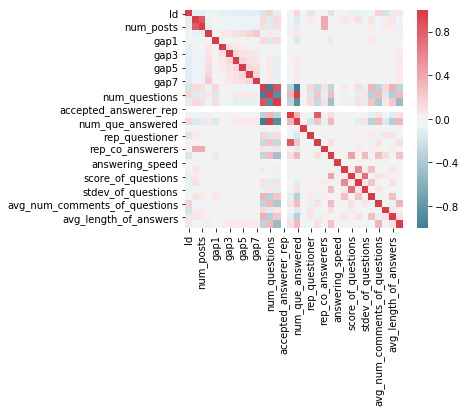

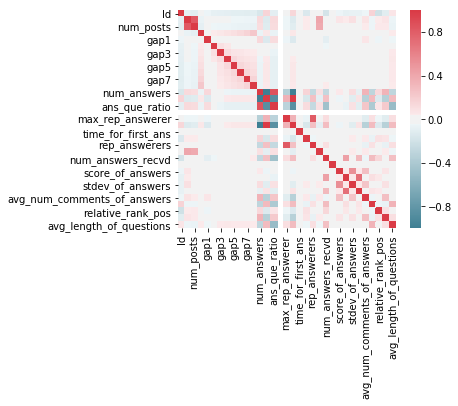

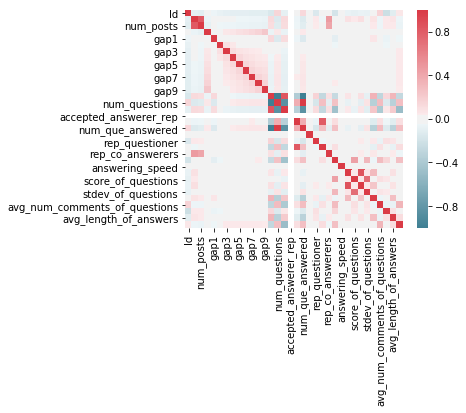

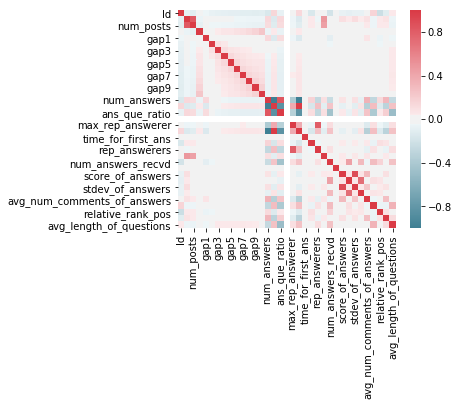

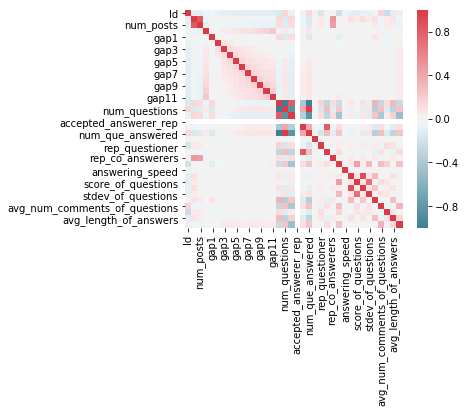

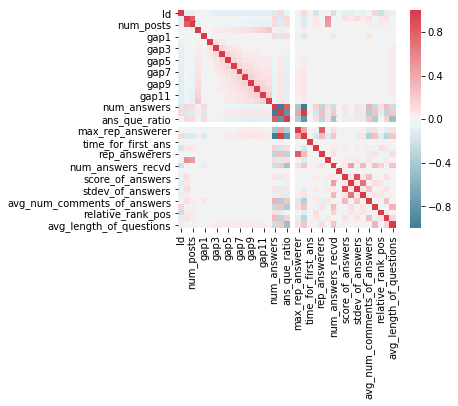

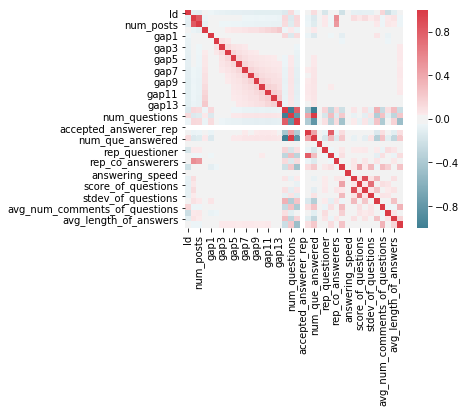

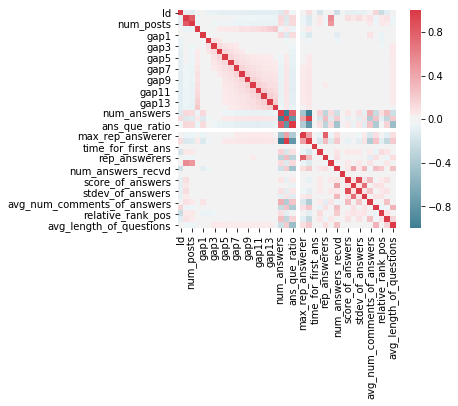

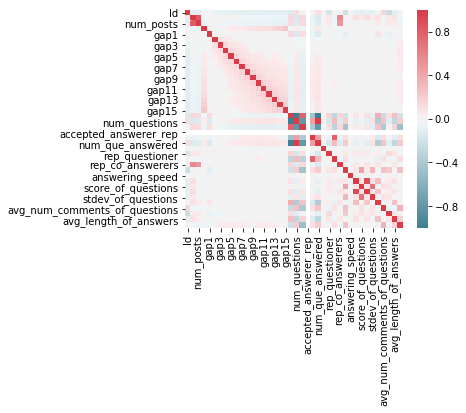

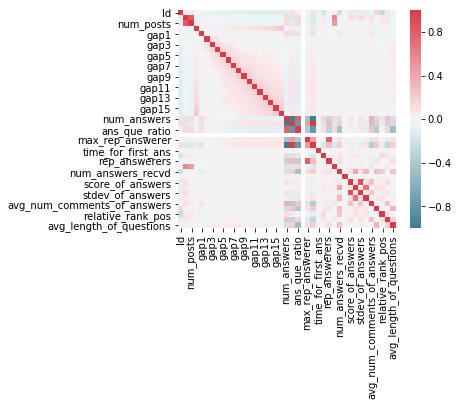

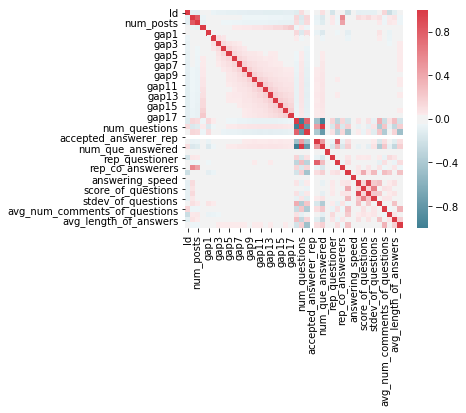

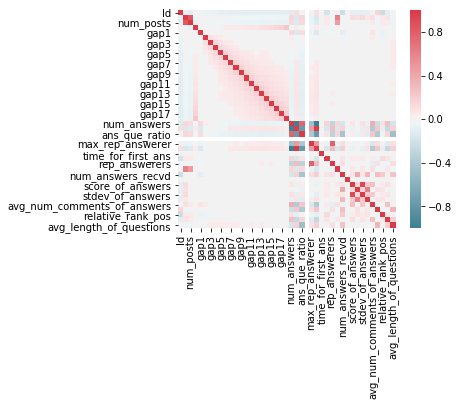

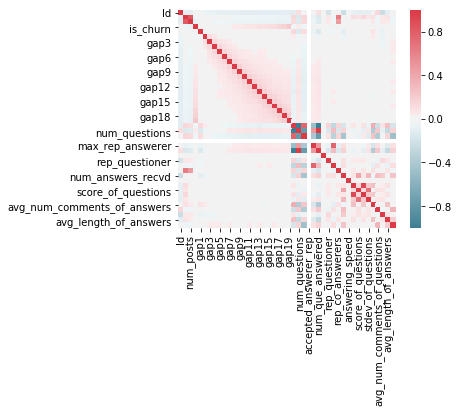

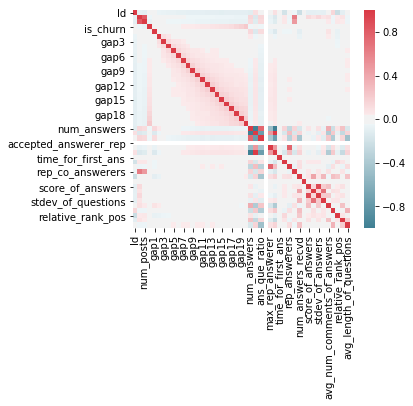

In [202]:
#Figure correlation of Task1

# for K in list_of_K:
#   f, ax = plt.subplots(figsize=(5,4))
#   corr=features_of_task1[K].corr()
# #   plt.figure()
#   sns_plot = sns.heatmap(corr, mask=np.zeros_like(corr,dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
#             square=True, ax=ax)
# #   plt.savefig('task1_{}posts_corr.png'.format(K))


pandas.core.frame.DataFrame

In [164]:
store_df_at_google_drive('task1_total_accuracy.csv',acc_df)

Uploaded file with ID 1vNJhuKuhhGtGve9O5daIOYxTDSVSuTUz


In [175]:
acc_df

,DT,LR
1,58.6607,51.9871
2,56.5535,41.1291
3,57.6649,59.9626
4,58.8388,61.5248
5,60.2377,61.3623
6,60.9562,61.1908
7,61.9006,60.7126
8,62.7837,61.0219
9,63.7919,60.3845
10,63.8387,61.5955


In [167]:
# Table 3: Performance on Task 2
# models = [DecisionTreeClassifier, LogisticRegression_, SVC_rbf, SVC_linear]
# modelnames=['DT','LR']
task2_acc_df=pd.DataFrame(columns=['DTmean','DTvar','LRmean','LRvar'])
drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate']

# model = LogisticRegression_
# model = DecisionTreeClassifier
# models = [SVC_rbf, SVC_linear, DecisionTreeClassifier, LogisticRegression_]

for i in range(len(models)):
  model  = models[i]
  for T in list_of_T:
      stime=time.time()
      print('Task 2, T={0}, start : {1}'.format(T, stime))
      train_features = [col for col in features_of_task2[T].columns 
                        if col not in drop_user_columns + ['is_churn']]

      acc_list = learn_model(features_of_task2[T], train_features, model=model)
      task2_acc_df.set_value(T,modelname[i]+'mean',np.mean(acc_list))
      task2_acc_df.set_value(T,modelname[i]+'var',np.var(acc_list))
      print('Accuracy: {} VAR : {}'.format(np.mean(acc_list), np.var(acc_list)))
      print('    for each folds: {}'.format(acc_list))
      print('end : {0}, execution time : {1}'.format(time.time(), time.time()-stime))


Task 2, T=7, start : 1571807860.5696795
DecisionTreeClassifier
churn : 245574, stay : 149035
after sampling : churn : 149035, stay : 149035
churn : 245730, stay : 148879
after sampling : churn : 148879, stay : 148879
churn : 245603, stay : 149006
after sampling : churn : 149006, stay : 149006
churn : 245685, stay : 148924
after sampling : churn : 148924, stay : 148924
churn : 245654, stay : 148955
after sampling : churn : 148955, stay : 148955
churn : 245400, stay : 149210
after sampling : churn : 149210, stay : 149210
churn : 245573, stay : 149037
after sampling : churn : 149037, stay : 149037
churn : 245656, stay : 148954
after sampling : churn : 148954, stay : 148954
churn : 245383, stay : 149227
after sampling : churn : 149227, stay : 149227
churn : 245536, stay : 149074
after sampling : churn : 149074, stay : 149074


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 61.91513273785402 VAR : 0.03422683170978176
    for each folds: [62.15846371390777, 62.23828855539844, 61.725128860101265, 61.94635770651827, 61.98284906262829, 61.87934770213251, 61.79267875470407, 61.78355570760634, 61.61477933629833, 62.029877979245065]
end : 1571807922.3247907, execution time : 61.75511145591736
Task 2, T=15, start : 1571807922.324823
DecisionTreeClassifier
churn : 261783, stay : 147304
after sampling : churn : 147304, stay : 147304
churn : 261847, stay : 147240
after sampling : churn : 147240, stay : 147240
churn : 261933, stay : 147155
after sampling : churn : 147155, stay : 147155
churn : 261876, stay : 147212
after sampling : churn : 147212, stay : 147212
churn : 262109, stay : 146979
after sampling : churn : 146979, stay : 146979
churn : 261893, stay : 147195
after sampling : churn : 147195, stay : 147195
churn : 261800, stay : 147288
after sampling : churn : 147288, stay : 147288
churn : 261919, stay : 147169
after sampling : churn : 147169, stay : 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 63.61106331735997 VAR : 0.0931658321493409
    for each folds: [63.73336266637334, 63.54636453635464, 63.27275927311128, 64.01416817001804, 63.91076692920315, 63.58736304835658, 63.04395652747833, 63.31015972191666, 63.95256743080917, 63.73916486997844]
end : 1571807986.196623, execution time : 63.87180042266846
Task 2, T=30, start : 1571807986.1975527
DecisionTreeClassifier
churn : 279873, stay : 144869
after sampling : churn : 144869, stay : 144869
churn : 279906, stay : 144836
after sampling : churn : 144836, stay : 144836
churn : 280010, stay : 144732
after sampling : churn : 144732, stay : 144732
churn : 280013, stay : 144729
after sampling : churn : 144729, stay : 144729
churn : 280059, stay : 144683
after sampling : churn : 144683, stay : 144683
churn : 280022, stay : 144720
after sampling : churn : 144720, stay : 144720
churn : 279966, stay : 144777
after sampling : churn : 144777, stay : 144777
churn : 279925, stay : 144818
after sampling : churn : 144818, stay : 144

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 65.30906823258701 VAR : 0.08717295811863365
    for each folds: [65.0718311649786, 65.37695469763105, 65.14175530787811, 65.45323558079417, 65.30067381446794, 65.08454464550579, 65.7216112559066, 65.23636980060603, 65.8678193799928, 64.83588667810905]
end : 1571808060.0781174, execution time : 73.88056492805481
Task 2, T=7, start : 1571808060.0784647
LogisticRegression_
churn : 245574, stay : 149035
after sampling : churn : 149035, stay : 149035


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245730, stay : 148879
after sampling : churn : 148879, stay : 148879


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245603, stay : 149006
after sampling : churn : 149006, stay : 149006


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245685, stay : 148924
after sampling : churn : 148924, stay : 148924


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245654, stay : 148955
after sampling : churn : 148955, stay : 148955


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245400, stay : 149210
after sampling : churn : 149210, stay : 149210


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245573, stay : 149037
after sampling : churn : 149037, stay : 149037


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245656, stay : 148954
after sampling : churn : 148954, stay : 148954


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245383, stay : 149227
after sampling : churn : 149227, stay : 149227


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 245536, stay : 149074
after sampling : churn : 149074, stay : 149074


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 69.35033330015133 VAR : 0.02320227411344748
    for each folds: [69.23322537973817, 69.29024312366008, 69.41340145053141, 69.17620763581627, 69.25147105779318, 69.39673851066256, 69.2804196601665, 69.27129661306877, 69.73201049150416, 69.45831907857225]
end : 1571808316.1540358, execution time : 256.0755717754364
Task 2, T=15, start : 1571808316.154115
LogisticRegression_
churn : 261783, stay : 147304
after sampling : churn : 147304, stay : 147304


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261847, stay : 147240
after sampling : churn : 147240, stay : 147240


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261933, stay : 147155
after sampling : churn : 147155, stay : 147155


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261876, stay : 147212
after sampling : churn : 147212, stay : 147212


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 262109, stay : 146979
after sampling : churn : 146979, stay : 146979


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261893, stay : 147195
after sampling : churn : 147195, stay : 147195


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261800, stay : 147288
after sampling : churn : 147288, stay : 147288


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261919, stay : 147169
after sampling : churn : 147169, stay : 147169


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261877, stay : 147211
after sampling : churn : 147211, stay : 147211


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 261891, stay : 147197
after sampling : churn : 147197, stay : 147197


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Accuracy: 72.78205268459922 VAR : 0.02536192170780281
    for each folds: [72.87867121328787, 72.8940710592894, 72.83407400888811, 72.55027060324724, 72.58767105205263, 72.91987503850046, 72.85167422009064, 72.51727020724249, 72.79667356008272, 72.9902758833106]
end : 1571808564.3219535, execution time : 248.16783905029297
Task 2, T=30, start : 1571808564.3228765
LogisticRegression_
churn : 279873, stay : 144869
after sampling : churn : 144869, stay : 144869


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 279906, stay : 144836
after sampling : churn : 144836, stay : 144836


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 280010, stay : 144732
after sampling : churn : 144732, stay : 144732


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 280013, stay : 144729
after sampling : churn : 144729, stay : 144729


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 280059, stay : 144683
after sampling : churn : 144683, stay : 144683


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 280022, stay : 144720
after sampling : churn : 144720, stay : 144720


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 279966, stay : 144777
after sampling : churn : 144777, stay : 144777


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 279925, stay : 144818
after sampling : churn : 144818, stay : 144818


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 280031, stay : 144712
after sampling : churn : 144712, stay : 144712


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


churn : 280086, stay : 144657
after sampling : churn : 144657, stay : 144657
Accuracy: 75.27249490153098 VAR : 0.015751100384053744
    for each folds: [75.40153409331695, 75.3527990846294, 75.04555663855575, 75.11759969487646, 75.35068017120821, 75.21295079883036, 75.4222024452779, 75.24632890471044, 75.401012862077, 75.17428432182739]
end : 1571808821.11639, execution time : 256.7935137748718


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [168]:
store_df_at_google_drive('task2_total_accuracy.csv',task2_acc_df)
task2_acc_df

Uploaded file with ID 1hPDwWzFWk06pVt-Z-Uz-GZ0W9YGo67zm


,DTmean,DTvar,LRmean,LRvar
7,61.9151,0.0342268,69.3503,0.0232023
15,63.6111,0.0931658,72.7821,0.0253619
30,65.3091,0.087173,75.2725,0.0157511


In [0]:
from google.colab import files

In [0]:


# df1=load_df_at_google_drive('task1_total_accuracy.csv')
# df2=load_df_at_google_drive('task2_total_accuracy.csv')
acc_df.to_csv('task1_total_accuracy.csv')
# task2_acc_df.to_csv('task2_total_accuracy.csv')
files.download('task1_total_accuracy.csv')
# files.download('task2_total_accuracy.csv')

In [0]:
# Figure 5: Churn prediction accuracy when features from each category are used in isolation

temporal_features = ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
frequency_features = ['num_answers', 'num_questions',
                      'ans_que_ratio', 'num_posts']
speed_features = ['answering_speed']
quality_features = ['ans_score', 'que_score']
consistency_features = ['ans_stddev', 'que_stddev']
gratitude_features = ['ans_comments', 'que_comments']
competitiveness_features = ['relative_rank_pos']
content_features = ['ans_length', 'que_length']
knowledge_features = ['accepted_answerer_rep', 'max_rep_answerer',
                      'num_que_answered', 'time_for_first_ans',
                      'rep_questioner', 'rep_answerers',
                      'rep_co_answerers', 'num_answers_recvd']

analysis_feature_names = {
    'temporal': temporal_features,
    'frequency': frequency_features,
    'speed': speed_features,
    'quality': quality_features,
    'consistency': consistency_features,
    'gratitude': gratitude_features,
    'competitiveness': competitiveness_features,
    'content': content_features,
    'knowledge': knowledge_features,
}

In [0]:
task1_accuracy_of_category = {}
for name, feature_list in analysis_feature_names.items():
    accuracy_of_category = []
    for K in list_of_K:
        if name == 'temporal':
            feature_list = ['gap{}'.format(j) for j in range(1, K+1)]
        elif name == 'frequency':
            features_list = [feat for feat in feature_list if feat != 'num_posts']
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        stime = time.time()
        print('\n{}, Task 1, K={}, start : {}'.format(name, K, stime))
        print('    columns: {}'.format(train_features))
         
        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_of_category.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))
        print('end : {}, execution time : {}'.format(time.time(), time.time()-stime))
    task1_accuracy_of_category[name] = accuracy_of_category

In [0]:
# Bar Chart
for title, predictions in task1_accuracy_of_category.items():
    if len(predictions) == 0:
        continue
    n_groups = len(list_of_K)
    index = np.arange(n_groups)

    plt.bar(index, predictions, tick_label=list_of_K, align='center')

    plt.title(title)
    plt.xlim(-1, n_groups)
    plt.ylim(40, 100)
    
    plt.savefig('task1_{}_accuracy.png'.format(title))
    plt.show()
    store_df_at_google_drive('task1_{}_accuracy'.format(title),pd.DataFrame(),'png')

In [0]:
### Category Analysis - Task 2 ###
task2_accuracy_of_category = {}
for name, feature_list in analysis_feature_names.items():
    accuracy_of_category = []
    for T in list_of_T:
        train_features = [feat for feat in feature_list if feat in features_of_task2[T].columns]
        if len(train_features) == 0:
            continue
        stime = time.time()
        print('\n{}, Task 2, T={}, start : {}'.format(name, T, stime))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task2[T], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_of_category.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))
        print('end : {}, execution time : {}'.format(time.time(), time.time()-stime))

    task2_accuracy_of_category[name] = accuracy_of_category

In [0]:
# Bar Chart
for title, predictions in task2_accuracy_of_category.items():
    if len(predictions) == 0:
        continue
    n_groups = len(list_of_T)
    index = np.arange(n_groups)

    plt.bar(index, predictions, tick_label=list_of_T, align='center')

    plt.title(title)
    plt.xlim(-1, n_groups)
    plt.ylim(50, 80)
    plt.savefig('task2_{}_accuracy.png'.format(title))
    plt.show()
    store_df_at_google_drive('task2_{}_accuracy'.format(title),pd.DataFrame(),'png')

In [0]:
### Temporal Feature Analysis - Task 1 ###
temporal_analysis_feature_func = {
    'gapK': lambda K: ['gap{}'.format(j) for j in range(1, K+1)],
    'last_gap': lambda K: ['gap{}'.format(K)]
}


task1_accuracy_with_time_gap = {}
for K in list_of_K:
    accuracy_with_time_gap = []
    for name, feature_func in temporal_analysis_feature_func.items():
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        stime = time.time()
        print('\n{}, Task 1, K={}, start : {}'.format(name, K, stime))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_with_time_gap.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))
        print('execution time : {}'.format(time.time()-stime))

    task1_accuracy_with_time_gap[K] = accuracy_with_time_gap

In [0]:
# Table 4: Temporal gap features analysis

for K, acc in task1_accuracy_with_time_gap.items():
    print(K, acc)